# <span style = "background-color: #FFDDDD"> 없다면 어떻게 될까? (ResNet Ablation Study)</span>

⭐️ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.  
⭐️구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.  
⭐️Ablation Study 결과가 바른 포맷으로 제출되었는가? ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

---
## <span style = "background-color: #FFFFDD"> 🍒 Environment Setting</span>

### <span style = "background-color: #F0E9FF"> 1. Import libraries & packages </span>

In [1]:
# data handling
import numpy as np


# visualization
import matplotlib.pyplot as plt


# dataset API
import urllib3
import tensorflow_datasets as tfds


# ML/DL 
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models

# ignore warning messages for corrupted image data files
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_datasets")

### <span style = "background-color: #F0E9FF"> 2. Define constants</span>

In [2]:
# image data configurations
CAT = 0
DOG = 1

TOTAL_CLASSES_CNT = 2

In [3]:
# machine learning configurations
IMG_SIZE = 224

TRAIN_SAMPLES_CNT = 17446
TEST_SAMPLES_CNT = 5816

BATCH_SIZE = 64
EPOCHS = 30

### <span style = "background-color: #F0E9FF"> 3. Define frequently used methods</span>

In [4]:
DIVIDER_LENGTH = 80

def print_single_divider(length = DIVIDER_LENGTH):
    print("-" * DIVIDER_LENGTH)

def print_double_divider(length = DIVIDER_LENGTH):
    print("=" * DIVIDER_LENGTH)

---
## <span style = "background-color: #FFFFDD"> 🍒 Data Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Load dataset</span>

In [5]:
# set dataset url download configurations
urllib3.disable_warnings()

In [6]:
# set dataset url
setattr(tfds.image_classification.cats_vs_dogs,
        "_URL","https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [7]:
(ds_train, ds_test), ds_info = tfds.load("cats_vs_dogs",
                                         split=["train[:75%]", "train[75%:]"],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True,                                        )

print("The dataset has been loaded successfully!")

The dataset has been loaded successfully!


### <span style = "background-color: #F0E9FF"> 2. Preview data</span>

**2-1. Get data information**

In [8]:
# check the dataset feature information
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [9]:
# check the number of train/test data samples
print(">>> The number of train data samples : ", tf.data.experimental.cardinality(ds_train))
print(">>> The number of test data samples  : ", tf.data.experimental.cardinality(ds_test))

>>> The number of train data samples :  tf.Tensor(17446, shape=(), dtype=int64)
>>> The number of test data samples  :  tf.Tensor(5816, shape=(), dtype=int64)


In [10]:
# check the label information
print(">>> The number of labels             : ", ds_info.features["label"].num_classes)
print(">>> List of labels                   : ", ds_info.features["label"].names)

>>> The number of labels             :  2
>>> List of labels                   :  ['cat', 'dog']


**2-2. Preview image data samples**

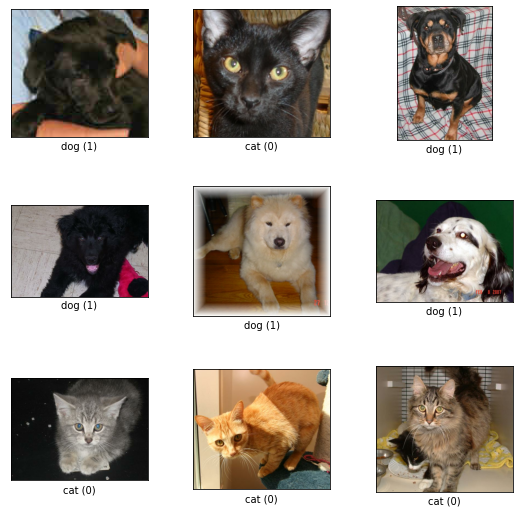

In [11]:
# preview TRAIN image data samples
preview_train = tfds.show_examples(ds_train, ds_info)
preview_train.show()

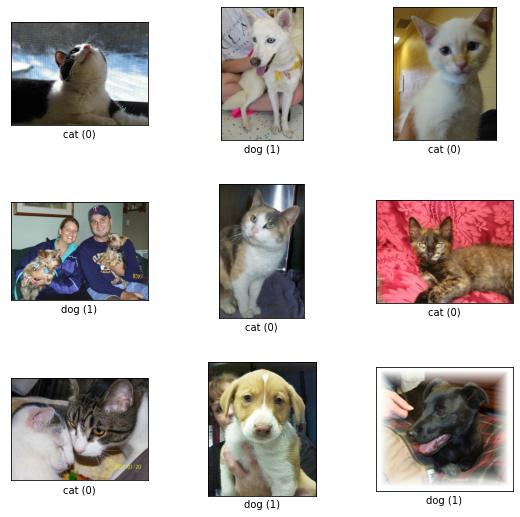

In [12]:
# preivew TEST image data samples
preview_test = tfds.show_examples(ds_test, ds_info)
preview_test.show()

### <span style = "background-color: #F0E9FF"> 3. Pre-process data</span>

**3-1. Define pre-processing methods**

In [13]:
# normalization method
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [14]:
# pipelline method for normalization & data usage configuration setting
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    # normalization
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    
    
    # data usage configurations
    ds = ds.batch(batch_size)
    
    if not is_test: # set additional configurations for training data (not test) 
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    
    return ds

**3-2. Pre-process data**

In [15]:
# pre-process TRAIN data
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=BATCH_SIZE)
print("Pre-process for TRAIN data has finished successfully!")

# pre-process TEST data
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)
print("Pre-process for TEST data has finished successfully!")

Pre-process for TRAIN data has finished successfully!
Pre-process for TEST data has finished successfully!


---
## <span style = "background-color: #FFFFDD"> 🍒 Model Design</span>

### <span style = "background-color: #F0E9FF"> 1. Design model structure</span>

**1-1. Comparison between plain network & ResNet with 34-layer**

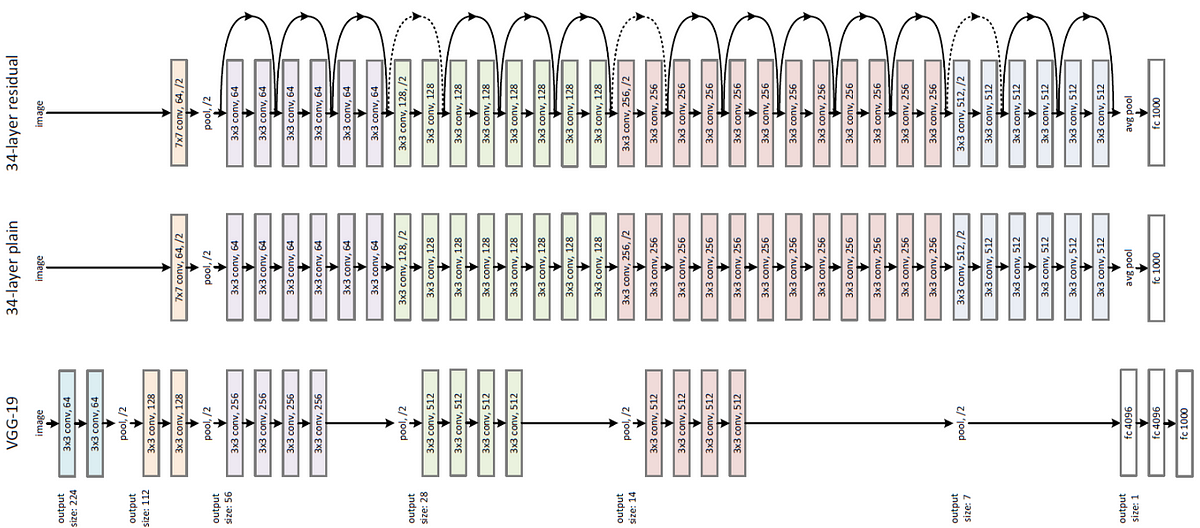

**1-2. Comparison between 34-layer & 50-layer ResNet**

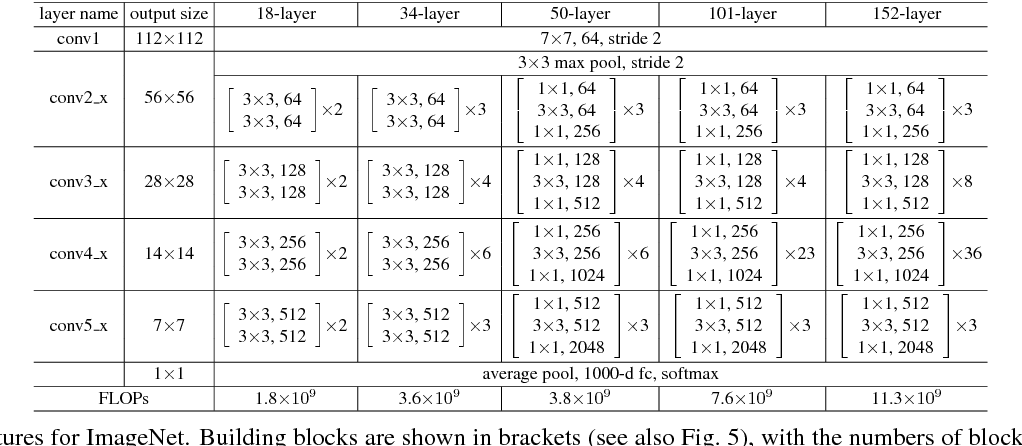

**1-3. Analysis of basic layer block of ResNet**

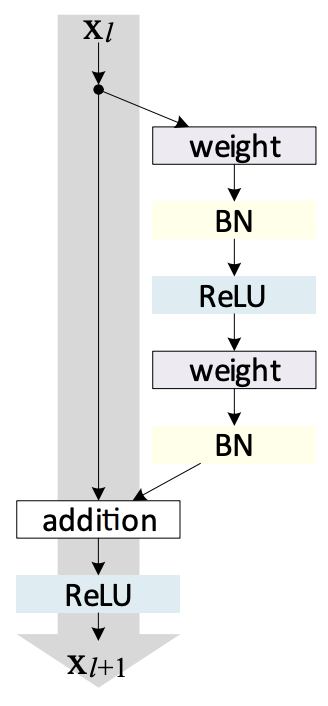

### <span style = "background-color: #F0E9FF"> 2. Define the layer block</span>

In [16]:
def build_resnet_block(inputs, channels, resnet_layer, down_sampling=False, shortcut=False):
    KERNEL_INIT = "he_normal"
    
    strides = [2, 1] if down_sampling else [1, 1]
    
    padding_opt = "same"
    kernel_size = (3, 3)
    
    if resnet_layer > 34:
        padding_opt = "valid"
        kernel_size = (1, 1)

    
    # input layer
    x = inputs
    
    
    # 1st convolution layer
    x = layers.Conv2D(channels, strides=strides[0], kernel_size=kernel_size, padding=padding_opt, kernel_initializer=KERNEL_INIT)(x)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    
    # additional layer for large ResNet (bigger than 34)
    if resnet_layer > 34:
        x = layers.Conv2D(channels, strides=strides[1], kernel_size=(3,3), padding="same", kernel_initializer=KERNEL_INIT)(x)
        x = layers.BatchNormalization()(x)
        x = tf.nn.relu(x)

    # 2nd convolution layer
    if resnet_layer > 34:
        channels = channels * 4
    x = layers.Conv2D(channels, strides=strides[1], kernel_size=kernel_size, padding=padding_opt, kernel_initializer=KERNEL_INIT)(x)
    x = layers.BatchNormalization()(x)

    
    
    if shortcut == True:    # ResNet with shortcut connection
        # shortcut connection
        if down_sampling:
            res = layers.Conv2D(channels, strides=2, kernel_size=(1,1), kernel_initializer=KERNEL_INIT, padding="same")(inputs)
            res = layers.BatchNormalization()(res)
        else:
            res = inputs

        # resize shortcut connection if needed
        if res.shape[-1] != x.shape[-1]:
            res = layers.Conv2D(x.shape[-1], kernel_size=(1,1), strides=strides[0], padding="same", kernel_initializer=KERNEL_INIT)(res)
            res = layers.BatchNormalization()(res)

        # merge with shortcut connection
        x = layers.add([x, res])
    
    
    x = tf.nn.relu(x)
    
    return x

### <span style = "background-color: #F0E9FF"> 3. Define full model structure</span>

**3-1. Define ResNet model method**

In [17]:
def build_resnet(resnet_layer=34, input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT, shortcut=True):
    # input layer
    inputs = layers.Input(shape=input_shape)
    
    # 1st layer
    x = layers.Conv2D(64, (7,7), strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
    x = layers.MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)
    
    
    
    # 2nd ~ 5th layer (repetition of residual blocks)
    block_repeat = {18: [2, 2, 2, 2],
                    34: [3, 4, 6, 3],
                    50: [3, 4, 6, 3],
                    101: [3, 4, 23, 3],
                    152: [3, 8, 36, 3]}
    channels = [64, 128, 256, 512]
    
    for i in range(4):
        for j in range(block_repeat[resnet_layer][i]):
            down_sampling = False
            if i != 0 and j == 0:
                down_sampling = True
                
            x = build_resnet_block(x, resnet_layer=resnet_layer, channels=channels[i], down_sampling=down_sampling, shortcut=shortcut)
        
    
    # output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation="softmax")(x)
    outputs = x
    
    
    # return model
    model = models.Model(inputs, outputs)
    return model

**3-2. Define plain network (ResNet without skip connection) model method**

In [18]:
def build_plainnet(resnet_layer=34, input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=TOTAL_CLASSES_CNT):
    model = build_resnet(resnet_layer=resnet_layer, input_shape=input_shape, num_classes=num_classes, shortcut=False)
    return model

**3-3. Check valideness of model constructure**  
프로젝트 노드의 예시와 동일한 model instance를 생성하여, 노드 예시와 layer 구조를 비교 (ResNet-34, ResNet-50이 올바르게 잘 구현되었는지 확인) 

In [19]:
# ResNet-34 sample with same parameters suggested in programming guide
resnet_34_test = build_resnet(resnet_layer=34, input_shape=(32, 32, 3), num_classes=10)
resnet_34_test.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

💡 프로젝트 노드 예시와 같이 CIFAR-10 기준으로 모델 객체 생성 결과, 모델 구조가 프로젝트 노드에 제시된 구조와 동일함을 확인하였다.  

```
Total params: 21,315,338
Trainable params: 21,298,314
Non-trainable params: 17,024
```

In [20]:
# ResNet-50 sample with same parameters suggested in programming guide
resnet_50_test = build_resnet(resnet_layer=50, input_shape=(32, 32, 3), num_classes=10)
resnet_50_test.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu_33 (TFOpLambda)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

💡 프로젝트 노드 예시와 같이 CIFAR-10 기준으로 모델 객체 생성 결과, 모델 구조가 프로젝트 노드에 제시된 구조와 동일함을 확인하였다.  
프로젝트 노드 예시에서는 마지막 2개의 레이어 (pooling layer, dense layer) 가 구현되지 않았으므로, 파라미터의 갯수가 다소 차이가 난다. 

```
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
```

### <span style = "background-color: #F0E9FF"> 4. Generate model instances</span>

**4-1. Generate ResNet-34 model instance**

In [21]:
resnet_34 = build_resnet(resnet_layer=34, input_shape=(IMG_SIZE, IMG_SIZE,3))
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 112, 112, 64) 256         conv2d_89[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu_82 (TFOpLambda)      (None, 112, 112, 64) 0           batch_normalization_89[0][0]     
____________________________________________________________________________________________

**4-2. Generate ResNet-50 model instance**

In [22]:
resnet_50 = build_resnet(resnet_layer=50, input_shape=(IMG_SIZE, IMG_SIZE,3))
resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 112, 112, 64) 256         conv2d_125[0][0]                 
__________________________________________________________________________________________________
tf.nn.relu_115 (TFOpLambda)     (None, 112, 112, 64) 0           batch_normalization_125[0][0]    
____________________________________________________________________________________________

**4-3. Generate plain-34 model instance (ResNet-34 without shortcut connection)**

In [23]:
plainnet_34 = build_plainnet(resnet_layer=34, input_shape=(IMG_SIZE, IMG_SIZE,3))
plainnet_34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_178 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
tf.nn.relu_164 (TFOpLambda)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_179 (Bat (None, 56, 56, 64)        256 

**4-3. Generate plain-50 model instance (ResNet-34 without shortcut connection)**

In [24]:
plainnet_50 = build_plainnet(resnet_layer=50, input_shape=(IMG_SIZE, IMG_SIZE,3))
plainnet_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_211 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
tf.nn.relu_197 (TFOpLambda)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_212 (Bat (None, 56, 56, 64)        256 

---
## <span style = "background-color: #FFFFDD"> 🍒 Experiments</span>

In [25]:
experiments_dict = {"ResNet-34": {"model": resnet_34, "history": None},
                    "ResNet-50": {"model": resnet_50, "history": None},
                    "plain-34": {"model": plainnet_34, "history": None},
                    "plain-50": {"model": plainnet_50, "history": None}}

In [26]:
# compile and training with each model
for model_name in experiments_dict.keys():
    model = experiments_dict[model_name]["model"]
    
    print("Training for " + model_name + " has started...")
    print_single_divider()
    
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
                  metrics=["accuracy"],)

    experiments_dict[model_name]["history"] = model.fit(ds_train,
                                                       steps_per_epoch=int(TRAIN_SAMPLES_CNT/BATCH_SIZE),
                                                       validation_steps=int(TEST_SAMPLES_CNT/BATCH_SIZE),
                                                       epochs=EPOCHS,
                                                       validation_data=ds_test,
                                                       verbose=1,
                                                       use_multiprocessing=True,)
    
    print_single_divider()
    print("Training for " + model_name + " model is finished successfully!")
    print_double_divider()

Training for ResNet-34 has started...
--------------------------------------------------------------------------------
Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 42/272 [===>..........................] - ETA: 1:12 - loss: 0.6975 - accuracy: 0.5815

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 47/272 [====>.........................] - ETA: 1:10 - loss: 0.6956 - accuracy: 0.5811

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 1:09 - loss: 0.6926 - accuracy: 0.5817

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 1:05 - loss: 0.6894 - accuracy: 0.5897

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:04 - loss: 0.6878 - accuracy: 0.5906

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


156/272 [================>.............] - ETA: 37s - loss: 0.6591 - accuracy: 0.6188

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 31s - loss: 0.6575 - accuracy: 0.6209

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


209/272 [======================>.......] - ETA: 20s - loss: 0.6519 - accuracy: 0.6254

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.6346

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 162s 369ms/step - loss: 0.6418 - accuracy: 0.6346 - val_loss: 0.8310 - val_accuracy: 0.5078
Epoch 2/30
 41/272 [===>..........................] - ETA: 1:23 - loss: 0.6089 - accuracy: 0.6608

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/272 [====>.........................] - ETA: 1:21 - loss: 0.6089 - accuracy: 0.6624

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 1:19 - loss: 0.6075 - accuracy: 0.6633

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 1:17 - loss: 0.6056 - accuracy: 0.6696

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:15 - loss: 0.6048 - accuracy: 0.6711

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


151/272 [===============>..............] - ETA: 43s - loss: 0.5906 - accuracy: 0.6805

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


173/272 [==================>...........] - ETA: 35s - loss: 0.5886 - accuracy: 0.6816

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/272 [======================>.......] - ETA: 21s - loss: 0.5831 - accuracy: 0.6865

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.6907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 391ms/step - loss: 0.5781 - accuracy: 0.6907 - val_loss: 0.6284 - val_accuracy: 0.6606
Epoch 3/30
 43/272 [===>..........................] - ETA: 1:20 - loss: 0.5529 - accuracy: 0.7217

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 47/272 [====>.........................] - ETA: 1:19 - loss: 0.5523 - accuracy: 0.7237

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 1:16 - loss: 0.5480 - accuracy: 0.7251

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:12 - loss: 0.5520 - accuracy: 0.7241

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:11 - loss: 0.5516 - accuracy: 0.7232

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


157/272 [================>.............] - ETA: 40s - loss: 0.5362 - accuracy: 0.7353

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 33s - loss: 0.5323 - accuracy: 0.7358

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


211/272 [======================>.......] - ETA: 21s - loss: 0.5282 - accuracy: 0.7399

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.7463

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.5185 - accuracy: 0.7463 - val_loss: 0.5396 - val_accuracy: 0.7304
Epoch 4/30
 43/272 [===>..........................] - ETA: 1:19 - loss: 0.4785 - accuracy: 0.7689

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 49/272 [====>.........................] - ETA: 1:17 - loss: 0.4770 - accuracy: 0.7707

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 1:15 - loss: 0.4728 - accuracy: 0.7738

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:11 - loss: 0.4693 - accuracy: 0.7755

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:10 - loss: 0.4711 - accuracy: 0.7756

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


159/272 [================>.............] - ETA: 39s - loss: 0.4643 - accuracy: 0.7777

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 33s - loss: 0.4629 - accuracy: 0.7779

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/272 [======================>.......] - ETA: 20s - loss: 0.4567 - accuracy: 0.7822

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.7862

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 386ms/step - loss: 0.4516 - accuracy: 0.7862 - val_loss: 0.5535 - val_accuracy: 0.7399
Epoch 5/30
 43/272 [===>..........................] - ETA: 1:20 - loss: 0.4326 - accuracy: 0.7994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 49/272 [====>.........................] - ETA: 1:18 - loss: 0.4320 - accuracy: 0.7975

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:16 - loss: 0.4253 - accuracy: 0.8023

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:11 - loss: 0.4183 - accuracy: 0.8058

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:10 - loss: 0.4182 - accuracy: 0.8068

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


159/272 [================>.............] - ETA: 39s - loss: 0.4122 - accuracy: 0.8097

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 33s - loss: 0.4107 - accuracy: 0.8103

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


214/272 [======================>.......] - ETA: 20s - loss: 0.4058 - accuracy: 0.8129

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4002 - accuracy: 0.8160

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.4002 - accuracy: 0.8160 - val_loss: 0.7851 - val_accuracy: 0.6667
Epoch 6/30
 44/272 [===>..........................] - ETA: 1:20 - loss: 0.3636 - accuracy: 0.8366

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 51/272 [====>.........................] - ETA: 1:17 - loss: 0.3703 - accuracy: 0.8333

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 1:15 - loss: 0.3685 - accuracy: 0.8340

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:10 - loss: 0.3581 - accuracy: 0.8411

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:09 - loss: 0.3569 - accuracy: 0.8412

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


160/272 [================>.............] - ETA: 39s - loss: 0.3416 - accuracy: 0.8486

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 33s - loss: 0.3378 - accuracy: 0.8516

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


214/272 [======================>.......] - ETA: 20s - loss: 0.3294 - accuracy: 0.8567

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8586

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 388ms/step - loss: 0.3262 - accuracy: 0.8586 - val_loss: 1.0506 - val_accuracy: 0.6392
Epoch 7/30
 45/272 [===>..........................] - ETA: 1:20 - loss: 0.2651 - accuracy: 0.8892

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 51/272 [====>.........................] - ETA: 1:17 - loss: 0.2548 - accuracy: 0.8961

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 1:15 - loss: 0.2536 - accuracy: 0.8955

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:10 - loss: 0.2588 - accuracy: 0.8900

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:09 - loss: 0.2600 - accuracy: 0.8898

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


162/272 [================>.............] - ETA: 38s - loss: 0.2573 - accuracy: 0.8918

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 33s - loss: 0.2604 - accuracy: 0.8909

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


215/272 [======================>.......] - ETA: 20s - loss: 0.2608 - accuracy: 0.8904

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.2544 - accuracy: 0.8935

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 389ms/step - loss: 0.2544 - accuracy: 0.8935 - val_loss: 0.6922 - val_accuracy: 0.7370
Epoch 8/30
 47/272 [====>.........................] - ETA: 1:19 - loss: 0.2051 - accuracy: 0.9202

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 1:17 - loss: 0.2047 - accuracy: 0.9186

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 1:15 - loss: 0.2020 - accuracy: 0.9195

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:10 - loss: 0.2050 - accuracy: 0.9171

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:09 - loss: 0.2035 - accuracy: 0.9177

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


161/272 [================>.............] - ETA: 39s - loss: 0.2025 - accuracy: 0.9185

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 32s - loss: 0.1993 - accuracy: 0.9206

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


216/272 [======================>.......] - ETA: 19s - loss: 0.1959 - accuracy: 0.9215

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9268

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 388ms/step - loss: 0.1840 - accuracy: 0.9268 - val_loss: 1.6330 - val_accuracy: 0.6304
Epoch 9/30
 47/272 [====>.........................] - ETA: 1:18 - loss: 0.1527 - accuracy: 0.9408

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 1:16 - loss: 0.1462 - accuracy: 0.9437

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 60/272 [=====>........................] - ETA: 1:14 - loss: 0.1464 - accuracy: 0.9440

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:09 - loss: 0.1403 - accuracy: 0.9439

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:08 - loss: 0.1404 - accuracy: 0.9434

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


162/272 [================>.............] - ETA: 38s - loss: 0.1359 - accuracy: 0.9468

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


181/272 [==================>...........] - ETA: 31s - loss: 0.1344 - accuracy: 0.9473

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


217/272 [======================>.......] - ETA: 19s - loss: 0.1310 - accuracy: 0.9492

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.9502

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 388ms/step - loss: 0.1286 - accuracy: 0.9502 - val_loss: 0.7942 - val_accuracy: 0.7542
Epoch 10/30
 48/272 [====>.........................] - ETA: 1:18 - loss: 0.1069 - accuracy: 0.9593

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 1:16 - loss: 0.1079 - accuracy: 0.9598

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:14 - loss: 0.1056 - accuracy: 0.9606

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:09 - loss: 0.1051 - accuracy: 0.9605

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:08 - loss: 0.1047 - accuracy: 0.9611

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/272 [=================>............] - ETA: 37s - loss: 0.1085 - accuracy: 0.9580

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


182/272 [===================>..........] - ETA: 31s - loss: 0.1077 - accuracy: 0.9578

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


218/272 [=======================>......] - ETA: 18s - loss: 0.1075 - accuracy: 0.9587

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.1030 - accuracy: 0.9608

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.1030 - accuracy: 0.9608 - val_loss: 0.9776 - val_accuracy: 0.7488
Epoch 11/30
 49/272 [====>.........................] - ETA: 1:18 - loss: 0.0914 - accuracy: 0.9662

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:16 - loss: 0.0903 - accuracy: 0.9670

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:13 - loss: 0.0895 - accuracy: 0.9672

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:09 - loss: 0.0897 - accuracy: 0.9665

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:07 - loss: 0.0901 - accuracy: 0.9661

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


166/272 [=================>............] - ETA: 37s - loss: 0.0952 - accuracy: 0.9631

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


183/272 [===================>..........] - ETA: 31s - loss: 0.0938 - accuracy: 0.9639

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


218/272 [=======================>......] - ETA: 18s - loss: 0.0938 - accuracy: 0.9640

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9642

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 386ms/step - loss: 0.0938 - accuracy: 0.9642 - val_loss: 0.8566 - val_accuracy: 0.7681
Epoch 12/30
 50/272 [====>.........................] - ETA: 1:17 - loss: 0.0856 - accuracy: 0.9681

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 57/272 [=====>........................] - ETA: 1:15 - loss: 0.0852 - accuracy: 0.9674

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:13 - loss: 0.0831 - accuracy: 0.9688

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:08 - loss: 0.0808 - accuracy: 0.9690

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 1:07 - loss: 0.0799 - accuracy: 0.9691

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/272 [=================>............] - ETA: 37s - loss: 0.0739 - accuracy: 0.9722

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


184/272 [===================>..........] - ETA: 30s - loss: 0.0746 - accuracy: 0.9714

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


221/272 [=======================>......] - ETA: 17s - loss: 0.0739 - accuracy: 0.9715

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9726

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.0727 - accuracy: 0.9726 - val_loss: 1.3229 - val_accuracy: 0.7132
Epoch 13/30
 52/272 [====>.........................] - ETA: 1:17 - loss: 0.0855 - accuracy: 0.9666

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 57/272 [=====>........................] - ETA: 1:15 - loss: 0.0851 - accuracy: 0.9677

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 1:13 - loss: 0.0871 - accuracy: 0.9668

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:08 - loss: 0.0871 - accuracy: 0.9661

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 1:07 - loss: 0.0863 - accuracy: 0.9666

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


167/272 [=================>............] - ETA: 36s - loss: 0.0784 - accuracy: 0.9704

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


184/272 [===================>..........] - ETA: 30s - loss: 0.0754 - accuracy: 0.9717

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


221/272 [=======================>......] - ETA: 17s - loss: 0.0764 - accuracy: 0.9712

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9720

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 389ms/step - loss: 0.0747 - accuracy: 0.9720 - val_loss: 1.8963 - val_accuracy: 0.6533
Epoch 14/30
 53/272 [====>.........................] - ETA: 1:16 - loss: 0.0700 - accuracy: 0.9762

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 1:14 - loss: 0.0686 - accuracy: 0.9761

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 65/272 [======>.......................] - ETA: 1:12 - loss: 0.0685 - accuracy: 0.9751

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:08 - loss: 0.0676 - accuracy: 0.9752

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 81/272 [=======>......................] - ETA: 1:07 - loss: 0.0675 - accuracy: 0.9754

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


169/272 [=================>............] - ETA: 36s - loss: 0.0596 - accuracy: 0.9777

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


186/272 [===================>..........] - ETA: 30s - loss: 0.0603 - accuracy: 0.9772

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


222/272 [=======================>......] - ETA: 17s - loss: 0.0600 - accuracy: 0.9776

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9782

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 388ms/step - loss: 0.0593 - accuracy: 0.9782 - val_loss: 0.9353 - val_accuracy: 0.7688
Epoch 15/30
 53/272 [====>.........................] - ETA: 1:17 - loss: 0.0483 - accuracy: 0.9814

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 59/272 [=====>........................] - ETA: 1:15 - loss: 0.0480 - accuracy: 0.9817

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 65/272 [======>.......................] - ETA: 1:13 - loss: 0.0474 - accuracy: 0.9822

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 1:08 - loss: 0.0446 - accuracy: 0.9836

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 82/272 [========>.....................] - ETA: 1:07 - loss: 0.0444 - accuracy: 0.9838

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


168/272 [=================>............] - ETA: 36s - loss: 0.0503 - accuracy: 0.9823

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


188/272 [===================>..........] - ETA: 29s - loss: 0.0494 - accuracy: 0.9828

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


223/272 [=======================>......] - ETA: 17s - loss: 0.0497 - accuracy: 0.9825

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9822

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 388ms/step - loss: 0.0499 - accuracy: 0.9822 - val_loss: 1.1161 - val_accuracy: 0.7608
Epoch 16/30
 55/272 [=====>........................] - ETA: 1:16 - loss: 0.0548 - accuracy: 0.9793

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:14 - loss: 0.0527 - accuracy: 0.9803

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 1:12 - loss: 0.0534 - accuracy: 0.9796

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 1:07 - loss: 0.0489 - accuracy: 0.9816

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 83/272 [========>.....................] - ETA: 1:06 - loss: 0.0495 - accuracy: 0.9812

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


170/272 [=================>............] - ETA: 35s - loss: 0.0499 - accuracy: 0.9807

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


188/272 [===================>..........] - ETA: 29s - loss: 0.0492 - accuracy: 0.9808

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


223/272 [=======================>......] - ETA: 17s - loss: 0.0501 - accuracy: 0.9801

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9814

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 388ms/step - loss: 0.0481 - accuracy: 0.9814 - val_loss: 1.5767 - val_accuracy: 0.7227
Epoch 17/30
 55/272 [=====>........................] - ETA: 1:16 - loss: 0.0524 - accuracy: 0.9810

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:14 - loss: 0.0524 - accuracy: 0.9808

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:11 - loss: 0.0534 - accuracy: 0.9798

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/272 [========>.....................] - ETA: 1:06 - loss: 0.0531 - accuracy: 0.9793

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 85/272 [========>.....................] - ETA: 1:05 - loss: 0.0516 - accuracy: 0.9801

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


170/272 [=================>............] - ETA: 35s - loss: 0.0447 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


189/272 [===================>..........] - ETA: 29s - loss: 0.0455 - accuracy: 0.9826

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


225/272 [=======================>......] - ETA: 16s - loss: 0.0443 - accuracy: 0.9832

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9823

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 388ms/step - loss: 0.0451 - accuracy: 0.9823 - val_loss: 1.6642 - val_accuracy: 0.7175
Epoch 18/30
 56/272 [=====>........................] - ETA: 1:15 - loss: 0.0424 - accuracy: 0.9834

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:13 - loss: 0.0407 - accuracy: 0.9843

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:11 - loss: 0.0404 - accuracy: 0.9847

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/272 [========>.....................] - ETA: 1:06 - loss: 0.0405 - accuracy: 0.9845

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 86/272 [========>.....................] - ETA: 1:05 - loss: 0.0400 - accuracy: 0.9845

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


172/272 [=================>............] - ETA: 35s - loss: 0.0428 - accuracy: 0.9846

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


190/272 [===================>..........] - ETA: 28s - loss: 0.0419 - accuracy: 0.9847

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


226/272 [=======================>......] - ETA: 16s - loss: 0.0405 - accuracy: 0.9855

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9859

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 388ms/step - loss: 0.0399 - accuracy: 0.9859 - val_loss: 1.2767 - val_accuracy: 0.7530
Epoch 19/30
 57/272 [=====>........................] - ETA: 1:15 - loss: 0.0367 - accuracy: 0.9852

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 1:13 - loss: 0.0380 - accuracy: 0.9846

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:11 - loss: 0.0378 - accuracy: 0.9851

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/272 [========>.....................] - ETA: 1:06 - loss: 0.0370 - accuracy: 0.9855

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 85/272 [========>.....................] - ETA: 1:05 - loss: 0.0376 - accuracy: 0.9855

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


172/272 [=================>............] - ETA: 35s - loss: 0.0378 - accuracy: 0.9861

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


191/272 [====================>.........] - ETA: 28s - loss: 0.0384 - accuracy: 0.9857

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


227/272 [========================>.....] - ETA: 15s - loss: 0.0381 - accuracy: 0.9864

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9870

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 388ms/step - loss: 0.0368 - accuracy: 0.9870 - val_loss: 1.3175 - val_accuracy: 0.7724
Epoch 20/30
 58/272 [=====>........................] - ETA: 1:15 - loss: 0.0329 - accuracy: 0.9881

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/272 [======>.......................] - ETA: 1:13 - loss: 0.0315 - accuracy: 0.9888

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:10 - loss: 0.0304 - accuracy: 0.9897

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 84/272 [========>.....................] - ETA: 1:06 - loss: 0.0313 - accuracy: 0.9894

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 88/272 [========>.....................] - ETA: 1:04 - loss: 0.0301 - accuracy: 0.9899

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


174/272 [==================>...........] - ETA: 34s - loss: 0.0321 - accuracy: 0.9893

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


191/272 [====================>.........] - ETA: 28s - loss: 0.0309 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


229/272 [========================>.....] - ETA: 15s - loss: 0.0321 - accuracy: 0.9893

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9887

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 389ms/step - loss: 0.0330 - accuracy: 0.9887 - val_loss: 3.3707 - val_accuracy: 0.6234
Epoch 21/30
 59/272 [=====>........................] - ETA: 1:15 - loss: 0.0350 - accuracy: 0.9883

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 65/272 [======>.......................] - ETA: 1:13 - loss: 0.0343 - accuracy: 0.9887

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:10 - loss: 0.0337 - accuracy: 0.9888

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 85/272 [========>.....................] - ETA: 1:05 - loss: 0.0332 - accuracy: 0.9890

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 88/272 [========>.....................] - ETA: 1:04 - loss: 0.0334 - accuracy: 0.9886

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 34s - loss: 0.0318 - accuracy: 0.9883

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


192/272 [====================>.........] - ETA: 28s - loss: 0.0307 - accuracy: 0.9887

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


229/272 [========================>.....] - ETA: 15s - loss: 0.0312 - accuracy: 0.9887

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9888

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 106s 389ms/step - loss: 0.0320 - accuracy: 0.9888 - val_loss: 1.0942 - val_accuracy: 0.7762
Epoch 22/30
 61/272 [=====>........................] - ETA: 1:14 - loss: 0.0307 - accuracy: 0.9898

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 1:12 - loss: 0.0302 - accuracy: 0.9898

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:10 - loss: 0.0292 - accuracy: 0.9895

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 1:05 - loss: 0.0295 - accuracy: 0.9890

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/272 [========>.....................] - ETA: 1:04 - loss: 0.0297 - accuracy: 0.9891

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 33s - loss: 0.0265 - accuracy: 0.9899

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


194/272 [====================>.........] - ETA: 27s - loss: 0.0257 - accuracy: 0.9902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


231/272 [========================>.....] - ETA: 14s - loss: 0.0257 - accuracy: 0.9902

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0272 - accuracy: 0.9898

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 388ms/step - loss: 0.0272 - accuracy: 0.9898 - val_loss: 1.1609 - val_accuracy: 0.7790
Epoch 23/30
 61/272 [=====>........................] - ETA: 1:13 - loss: 0.0243 - accuracy: 0.9923

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:11 - loss: 0.0257 - accuracy: 0.9920

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:09 - loss: 0.0263 - accuracy: 0.9919

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 1:04 - loss: 0.0273 - accuracy: 0.9912

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/272 [========>.....................] - ETA: 1:03 - loss: 0.0272 - accuracy: 0.9911

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 33s - loss: 0.0277 - accuracy: 0.9908

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/272 [====================>.........] - ETA: 26s - loss: 0.0266 - accuracy: 0.9911

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


231/272 [========================>.....] - ETA: 14s - loss: 0.0282 - accuracy: 0.9904

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.0274 - accuracy: 0.9907 - val_loss: 1.8385 - val_accuracy: 0.7092
Epoch 24/30
 63/272 [=====>........................] - ETA: 1:13 - loss: 0.0258 - accuracy: 0.9898

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:11 - loss: 0.0249 - accuracy: 0.9901

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:09 - loss: 0.0250 - accuracy: 0.9899

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 1:05 - loss: 0.0258 - accuracy: 0.9898

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/272 [========>.....................] - ETA: 1:04 - loss: 0.0260 - accuracy: 0.9899

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 33s - loss: 0.0244 - accuracy: 0.9913

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/272 [====================>.........] - ETA: 26s - loss: 0.0239 - accuracy: 0.9915

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


231/272 [========================>.....] - ETA: 14s - loss: 0.0230 - accuracy: 0.9918

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9918

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 388ms/step - loss: 0.0227 - accuracy: 0.9918 - val_loss: 1.1313 - val_accuracy: 0.7811
Epoch 25/30
 63/272 [=====>........................] - ETA: 1:12 - loss: 0.0219 - accuracy: 0.9943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:10 - loss: 0.0216 - accuracy: 0.9939

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:08 - loss: 0.0205 - accuracy: 0.9944

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 1:03 - loss: 0.0194 - accuracy: 0.9949

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 92/272 [=========>....................] - ETA: 1:02 - loss: 0.0196 - accuracy: 0.9947

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 32s - loss: 0.0200 - accuracy: 0.9937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/272 [====================>.........] - ETA: 26s - loss: 0.0190 - accuracy: 0.9938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/272 [========================>.....] - ETA: 13s - loss: 0.0197 - accuracy: 0.9933

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9934

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.0188 - accuracy: 0.9934 - val_loss: 1.3077 - val_accuracy: 0.7616
Epoch 26/30
 65/272 [======>.......................] - ETA: 1:12 - loss: 0.0207 - accuracy: 0.9935

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:10 - loss: 0.0196 - accuracy: 0.9940

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:08 - loss: 0.0210 - accuracy: 0.9932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 1:03 - loss: 0.0226 - accuracy: 0.9929

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 93/272 [=========>....................] - ETA: 1:02 - loss: 0.0228 - accuracy: 0.9927

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


179/272 [==================>...........] - ETA: 32s - loss: 0.0214 - accuracy: 0.9924

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/272 [====================>.........] - ETA: 25s - loss: 0.0206 - accuracy: 0.9928

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


234/272 [========================>.....] - ETA: 13s - loss: 0.0200 - accuracy: 0.9933

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 386ms/step - loss: 0.0200 - accuracy: 0.9932 - val_loss: 1.3877 - val_accuracy: 0.7672
Epoch 27/30
 66/272 [======>.......................] - ETA: 1:12 - loss: 0.0202 - accuracy: 0.9917

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:10 - loss: 0.0210 - accuracy: 0.9916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:07 - loss: 0.0217 - accuracy: 0.9918

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/272 [=========>....................] - ETA: 1:03 - loss: 0.0221 - accuracy: 0.9919

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 94/272 [=========>....................] - ETA: 1:02 - loss: 0.0219 - accuracy: 0.9920

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


181/272 [==================>...........] - ETA: 31s - loss: 0.0202 - accuracy: 0.9927

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/272 [====================>.........] - ETA: 25s - loss: 0.0195 - accuracy: 0.9929

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


234/272 [========================>.....] - ETA: 13s - loss: 0.0200 - accuracy: 0.9925

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9927

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 386ms/step - loss: 0.0194 - accuracy: 0.9927 - val_loss: 1.2973 - val_accuracy: 0.7783
Epoch 28/30
 67/272 [======>.......................] - ETA: 1:11 - loss: 0.0223 - accuracy: 0.9930

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:10 - loss: 0.0212 - accuracy: 0.9935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:07 - loss: 0.0213 - accuracy: 0.9932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/272 [=========>....................] - ETA: 1:03 - loss: 0.0200 - accuracy: 0.9937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 95/272 [=========>....................] - ETA: 1:02 - loss: 0.0196 - accuracy: 0.9939

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


181/272 [==================>...........] - ETA: 31s - loss: 0.0189 - accuracy: 0.9941

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/272 [=====================>........] - ETA: 25s - loss: 0.0191 - accuracy: 0.9941

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


236/272 [=========================>....] - ETA: 12s - loss: 0.0188 - accuracy: 0.9943

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9938

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.0196 - accuracy: 0.9938 - val_loss: 1.1321 - val_accuracy: 0.7804
Epoch 29/30
 68/272 [======>.......................] - ETA: 1:11 - loss: 0.0183 - accuracy: 0.9931

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:09 - loss: 0.0191 - accuracy: 0.9932

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 1:07 - loss: 0.0192 - accuracy: 0.9928

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/272 [=========>....................] - ETA: 1:02 - loss: 0.0193 - accuracy: 0.9926

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 97/272 [=========>....................] - ETA: 1:01 - loss: 0.0187 - accuracy: 0.9929

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


184/272 [===================>..........] - ETA: 30s - loss: 0.0182 - accuracy: 0.9931

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/272 [=====================>........] - ETA: 25s - loss: 0.0186 - accuracy: 0.9930

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


237/272 [=========================>....] - ETA: 12s - loss: 0.0182 - accuracy: 0.9932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 386ms/step - loss: 0.0184 - accuracy: 0.9932 - val_loss: 1.5216 - val_accuracy: 0.7552
Epoch 30/30
 68/272 [======>.......................] - ETA: 1:11 - loss: 0.0176 - accuracy: 0.9926

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:09 - loss: 0.0197 - accuracy: 0.9922

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/272 [=======>......................] - ETA: 1:06 - loss: 0.0186 - accuracy: 0.9927

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/272 [=========>....................] - ETA: 1:02 - loss: 0.0178 - accuracy: 0.9929

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 97/272 [=========>....................] - ETA: 1:01 - loss: 0.0177 - accuracy: 0.9929

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


184/272 [===================>..........] - ETA: 30s - loss: 0.0163 - accuracy: 0.9935

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/272 [=====================>........] - ETA: 24s - loss: 0.0164 - accuracy: 0.9935

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


239/272 [=========================>....] - ETA: 11s - loss: 0.0167 - accuracy: 0.9935

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9937

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 105s 387ms/step - loss: 0.0163 - accuracy: 0.9937 - val_loss: 1.3532 - val_accuracy: 0.7719
--------------------------------------------------------------------------------
Training for ResNet-34 model is finished successfully!
Training for ResNet-50 has started...
--------------------------------------------------------------------------------
Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 41/272 [===>..........................] - ETA: 2:37 - loss: 0.7088 - accuracy: 0.5595

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 46/272 [====>.........................] - ETA: 2:34 - loss: 0.7051 - accuracy: 0.5642

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 2:31 - loss: 0.7061 - accuracy: 0.5616

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 2:21 - loss: 0.7066 - accuracy: 0.5587

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 2:19 - loss: 0.7088 - accuracy: 0.5566

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


152/272 [===============>..............] - ETA: 1:22 - loss: 0.7015 - accuracy: 0.5607

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 1:06 - loss: 0.7006 - accuracy: 0.5614

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


209/272 [======================>.......] - ETA: 43s - loss: 0.6972 - accuracy: 0.5654

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.5717

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 228s 752ms/step - loss: 0.6942 - accuracy: 0.5717 - val_loss: 0.9207 - val_accuracy: 0.4939
Epoch 2/30
 44/272 [===>..........................] - ETA: 2:33 - loss: 0.6847 - accuracy: 0.5845

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 49/272 [====>.........................] - ETA: 2:30 - loss: 0.6803 - accuracy: 0.5906

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 2:28 - loss: 0.6788 - accuracy: 0.5910

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 2:18 - loss: 0.6767 - accuracy: 0.5968

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 2:17 - loss: 0.6774 - accuracy: 0.5956

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


159/272 [================>.............] - ETA: 1:15 - loss: 0.6721 - accuracy: 0.6013

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 1:03 - loss: 0.6721 - accuracy: 0.6034

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


213/272 [======================>.......] - ETA: 39s - loss: 0.6676 - accuracy: 0.6072

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.6129

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 737ms/step - loss: 0.6643 - accuracy: 0.6129 - val_loss: 0.8811 - val_accuracy: 0.5569
Epoch 3/30
 44/272 [===>..........................] - ETA: 2:33 - loss: 0.6610 - accuracy: 0.6250

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 2:29 - loss: 0.6593 - accuracy: 0.6241

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 57/272 [=====>........................] - ETA: 2:24 - loss: 0.6607 - accuracy: 0.6206

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 2:21 - loss: 0.6605 - accuracy: 0.6215

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


151/272 [===============>..............] - ETA: 1:21 - loss: 0.6588 - accuracy: 0.6189

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 1:04 - loss: 0.6581 - accuracy: 0.6191

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


214/272 [======================>.......] - ETA: 38s - loss: 0.6565 - accuracy: 0.6206

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.6243

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 738ms/step - loss: 0.6538 - accuracy: 0.6243 - val_loss: 1.1315 - val_accuracy: 0.5130
Epoch 4/30
 44/272 [===>..........................] - ETA: 2:33 - loss: 0.6560 - accuracy: 0.6112

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 49/272 [====>.........................] - ETA: 2:29 - loss: 0.6575 - accuracy: 0.6132

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 57/272 [=====>........................] - ETA: 2:24 - loss: 0.6564 - accuracy: 0.6154

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 2:15 - loss: 0.6523 - accuracy: 0.6165

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 2:13 - loss: 0.6507 - accuracy: 0.6179

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


158/272 [================>.............] - ETA: 1:16 - loss: 0.6463 - accuracy: 0.6326

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


179/272 [==================>...........] - ETA: 1:02 - loss: 0.6454 - accuracy: 0.6334

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


216/272 [======================>.......] - ETA: 37s - loss: 0.6439 - accuracy: 0.6345

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.6359

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 738ms/step - loss: 0.6432 - accuracy: 0.6359 - val_loss: 0.7777 - val_accuracy: 0.5976
Epoch 5/30
 43/272 [===>..........................] - ETA: 2:33 - loss: 0.6372 - accuracy: 0.6403

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 2:27 - loss: 0.6399 - accuracy: 0.6367

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 2:27 - loss: 0.6381 - accuracy: 0.6386

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 2:18 - loss: 0.6409 - accuracy: 0.6375

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 2:16 - loss: 0.6420 - accuracy: 0.6370

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


161/272 [================>.............] - ETA: 1:14 - loss: 0.6359 - accuracy: 0.6446

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


179/272 [==================>...........] - ETA: 1:02 - loss: 0.6366 - accuracy: 0.6428

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


214/272 [======================>.......] - ETA: 38s - loss: 0.6352 - accuracy: 0.6443

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.6426

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 739ms/step - loss: 0.6360 - accuracy: 0.6426 - val_loss: 0.9378 - val_accuracy: 0.5257
Epoch 6/30
 46/272 [====>.........................] - ETA: 2:32 - loss: 0.6402 - accuracy: 0.6345

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 2:27 - loss: 0.6402 - accuracy: 0.6344

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 2:26 - loss: 0.6404 - accuracy: 0.6341

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 2:16 - loss: 0.6341 - accuracy: 0.6359

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 2:14 - loss: 0.6334 - accuracy: 0.6378

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


163/272 [================>.............] - ETA: 1:13 - loss: 0.6294 - accuracy: 0.6472

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


181/272 [==================>...........] - ETA: 1:01 - loss: 0.6228 - accuracy: 0.6529

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


206/272 [=====================>........] - ETA: 44s - loss: 0.6231 - accuracy: 0.6549

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.6527

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 740ms/step - loss: 0.6241 - accuracy: 0.6527 - val_loss: 1.3553 - val_accuracy: 0.5087
Epoch 7/30
 48/272 [====>.........................] - ETA: 2:29 - loss: 0.6097 - accuracy: 0.6673

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 2:25 - loss: 0.6108 - accuracy: 0.6664

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 2:21 - loss: 0.6103 - accuracy: 0.6675

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 2:13 - loss: 0.6076 - accuracy: 0.6676

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 2:11 - loss: 0.6062 - accuracy: 0.6688

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


163/272 [================>.............] - ETA: 1:12 - loss: 0.6172 - accuracy: 0.6631

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 1:01 - loss: 0.6156 - accuracy: 0.6645

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


218/272 [=======================>......] - ETA: 36s - loss: 0.6144 - accuracy: 0.6655

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6134 - accuracy: 0.6671

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 736ms/step - loss: 0.6134 - accuracy: 0.6671 - val_loss: 0.6747 - val_accuracy: 0.6358
Epoch 8/30
 49/272 [====>.........................] - ETA: 2:29 - loss: 0.6187 - accuracy: 0.6677

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 2:27 - loss: 0.6167 - accuracy: 0.6686

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 2:26 - loss: 0.6160 - accuracy: 0.6690

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 2:17 - loss: 0.6177 - accuracy: 0.6656

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 2:15 - loss: 0.6163 - accuracy: 0.6650

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


163/272 [================>.............] - ETA: 1:13 - loss: 0.6059 - accuracy: 0.6693

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


182/272 [===================>..........] - ETA: 1:00 - loss: 0.6047 - accuracy: 0.6696

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


219/272 [=======================>......] - ETA: 35s - loss: 0.6026 - accuracy: 0.6743

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.6745

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 739ms/step - loss: 0.6026 - accuracy: 0.6745 - val_loss: 0.7338 - val_accuracy: 0.5938
Epoch 9/30
 50/272 [====>.........................] - ETA: 2:28 - loss: 0.6113 - accuracy: 0.6791

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 2:24 - loss: 0.6114 - accuracy: 0.6794

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 2:21 - loss: 0.6088 - accuracy: 0.6811

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 2:12 - loss: 0.6080 - accuracy: 0.6810

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 2:10 - loss: 0.6079 - accuracy: 0.6810

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


164/272 [=================>............] - ETA: 1:12 - loss: 0.6013 - accuracy: 0.6774

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


183/272 [===================>..........] - ETA: 59s - loss: 0.6013 - accuracy: 0.6770 

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


219/272 [=======================>......] - ETA: 35s - loss: 0.5997 - accuracy: 0.6787

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.6795

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 739ms/step - loss: 0.6003 - accuracy: 0.6795 - val_loss: 0.6795 - val_accuracy: 0.6306
Epoch 10/30
 50/272 [====>.........................] - ETA: 2:29 - loss: 0.6042 - accuracy: 0.6825

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 2:25 - loss: 0.6013 - accuracy: 0.6842

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 57/272 [=====>........................] - ETA: 2:24 - loss: 0.6012 - accuracy: 0.6845

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 2:15 - loss: 0.5980 - accuracy: 0.6866

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 2:12 - loss: 0.5973 - accuracy: 0.6881

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


166/272 [=================>............] - ETA: 1:11 - loss: 0.5973 - accuracy: 0.6868

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 1:01 - loss: 0.5961 - accuracy: 0.6888

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


221/272 [=======================>......] - ETA: 34s - loss: 0.5960 - accuracy: 0.6905

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.6896

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 740ms/step - loss: 0.5951 - accuracy: 0.6896 - val_loss: 0.9225 - val_accuracy: 0.6283
Epoch 11/30
 52/272 [====>.........................] - ETA: 2:27 - loss: 0.5897 - accuracy: 0.6872

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 2:25 - loss: 0.5864 - accuracy: 0.6889

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 2:20 - loss: 0.5893 - accuracy: 0.6870

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 2:11 - loss: 0.5880 - accuracy: 0.6854

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 2:09 - loss: 0.5895 - accuracy: 0.6841

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/272 [=================>............] - ETA: 1:11 - loss: 0.5805 - accuracy: 0.6926

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


185/272 [===================>..........] - ETA: 58s - loss: 0.5808 - accuracy: 0.6927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


222/272 [=======================>......] - ETA: 33s - loss: 0.5819 - accuracy: 0.6919

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.6933

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 739ms/step - loss: 0.5812 - accuracy: 0.6933 - val_loss: 1.2861 - val_accuracy: 0.5267
Epoch 12/30
 48/272 [====>.........................] - ETA: 2:30 - loss: 0.5781 - accuracy: 0.6934

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 2:23 - loss: 0.5777 - accuracy: 0.6972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 2:20 - loss: 0.5764 - accuracy: 0.6969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 2:11 - loss: 0.5744 - accuracy: 0.7027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 2:09 - loss: 0.5755 - accuracy: 0.7011

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/272 [=================>............] - ETA: 1:11 - loss: 0.5733 - accuracy: 0.7044

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


184/272 [===================>..........] - ETA: 58s - loss: 0.5721 - accuracy: 0.7042

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


223/272 [=======================>......] - ETA: 32s - loss: 0.5698 - accuracy: 0.7068

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5681 - accuracy: 0.7075

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 737ms/step - loss: 0.5681 - accuracy: 0.7075 - val_loss: 1.1169 - val_accuracy: 0.5535
Epoch 13/30
 51/272 [====>.........................] - ETA: 2:27 - loss: 0.5518 - accuracy: 0.7200

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 2:23 - loss: 0.5580 - accuracy: 0.7144

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 2:17 - loss: 0.5602 - accuracy: 0.7128

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 2:08 - loss: 0.5594 - accuracy: 0.7121

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 82/272 [========>.....................] - ETA: 2:07 - loss: 0.5584 - accuracy: 0.7127

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


166/272 [=================>............] - ETA: 1:11 - loss: 0.5567 - accuracy: 0.7112

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


188/272 [===================>..........] - ETA: 56s - loss: 0.5575 - accuracy: 0.7110

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


223/272 [=======================>......] - ETA: 32s - loss: 0.5547 - accuracy: 0.7144

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.7165

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 739ms/step - loss: 0.5523 - accuracy: 0.7165 - val_loss: 0.7580 - val_accuracy: 0.6250
Epoch 14/30
 55/272 [=====>........................] - ETA: 2:24 - loss: 0.5572 - accuracy: 0.7135

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 2:20 - loss: 0.5556 - accuracy: 0.7125

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 2:19 - loss: 0.5537 - accuracy: 0.7149

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 2:11 - loss: 0.5534 - accuracy: 0.7146

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 2:09 - loss: 0.5530 - accuracy: 0.7145

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


170/272 [=================>............] - ETA: 1:08 - loss: 0.5493 - accuracy: 0.7231

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/272 [===================>..........] - ETA: 56s - loss: 0.5515 - accuracy: 0.7220

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


220/272 [=======================>......] - ETA: 34s - loss: 0.5514 - accuracy: 0.7221

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7226

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 740ms/step - loss: 0.5493 - accuracy: 0.7226 - val_loss: 0.6028 - val_accuracy: 0.6920
Epoch 15/30
 55/272 [=====>........................] - ETA: 2:26 - loss: 0.5428 - accuracy: 0.7224

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 60/272 [=====>........................] - ETA: 2:22 - loss: 0.5418 - accuracy: 0.7229

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 2:18 - loss: 0.5380 - accuracy: 0.7246

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 2:09 - loss: 0.5358 - accuracy: 0.7258

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 83/272 [========>.....................] - ETA: 2:07 - loss: 0.5372 - accuracy: 0.7267

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


172/272 [=================>............] - ETA: 1:07 - loss: 0.5281 - accuracy: 0.7337

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


189/272 [===================>..........] - ETA: 55s - loss: 0.5285 - accuracy: 0.7336

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


224/272 [=======================>......] - ETA: 32s - loss: 0.5294 - accuracy: 0.7340

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.7332

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 739ms/step - loss: 0.5303 - accuracy: 0.7332 - val_loss: 0.6184 - val_accuracy: 0.6764
Epoch 16/30
 56/272 [=====>........................] - ETA: 2:24 - loss: 0.5212 - accuracy: 0.7377

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 2:19 - loss: 0.5145 - accuracy: 0.7438

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 2:10 - loss: 0.5185 - accuracy: 0.7397

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 2:08 - loss: 0.5189 - accuracy: 0.7391

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


172/272 [=================>............] - ETA: 1:06 - loss: 0.5253 - accuracy: 0.7401

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


189/272 [===================>..........] - ETA: 55s - loss: 0.5226 - accuracy: 0.7415

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


226/272 [=======================>......] - ETA: 30s - loss: 0.5203 - accuracy: 0.7420

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5178 - accuracy: 0.7445

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 739ms/step - loss: 0.5178 - accuracy: 0.7445 - val_loss: 0.6528 - val_accuracy: 0.6936
Epoch 17/30
 56/272 [=====>........................] - ETA: 2:24 - loss: 0.5109 - accuracy: 0.7469

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 2:19 - loss: 0.5090 - accuracy: 0.7490

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 64/272 [======>.......................] - ETA: 2:19 - loss: 0.5095 - accuracy: 0.7488

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 2:10 - loss: 0.5131 - accuracy: 0.7482

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 81/272 [=======>......................] - ETA: 2:07 - loss: 0.5135 - accuracy: 0.7471

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


173/272 [==================>...........] - ETA: 1:06 - loss: 0.5094 - accuracy: 0.7473

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


188/272 [===================>..........] - ETA: 56s - loss: 0.5077 - accuracy: 0.7474

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


225/272 [=======================>......] - ETA: 31s - loss: 0.5060 - accuracy: 0.7489

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.7520

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 737ms/step - loss: 0.5033 - accuracy: 0.7520 - val_loss: 0.8065 - val_accuracy: 0.6174
Epoch 18/30
 58/272 [=====>........................] - ETA: 2:23 - loss: 0.5016 - accuracy: 0.7656

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 2:20 - loss: 0.5059 - accuracy: 0.7626

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 2:15 - loss: 0.5056 - accuracy: 0.7621

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 84/272 [========>.....................] - ETA: 2:05 - loss: 0.5004 - accuracy: 0.7632

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 2:03 - loss: 0.4988 - accuracy: 0.7636

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


174/272 [==================>...........] - ETA: 1:05 - loss: 0.4874 - accuracy: 0.7700

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


192/272 [====================>.........] - ETA: 53s - loss: 0.4876 - accuracy: 0.7692

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


225/272 [=======================>......] - ETA: 31s - loss: 0.4897 - accuracy: 0.7671

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.7693

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 741ms/step - loss: 0.4857 - accuracy: 0.7693 - val_loss: 0.5941 - val_accuracy: 0.7161
Epoch 19/30
 57/272 [=====>........................] - ETA: 2:24 - loss: 0.4890 - accuracy: 0.7654

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 65/272 [======>.......................] - ETA: 2:18 - loss: 0.4905 - accuracy: 0.7630

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 2:14 - loss: 0.4898 - accuracy: 0.7634

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 84/272 [========>.....................] - ETA: 2:05 - loss: 0.4907 - accuracy: 0.7630

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 2:03 - loss: 0.4892 - accuracy: 0.7651

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


172/272 [=================>............] - ETA: 1:06 - loss: 0.4808 - accuracy: 0.7703

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


193/272 [====================>.........] - ETA: 52s - loss: 0.4770 - accuracy: 0.7734

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


230/272 [========================>.....] - ETA: 28s - loss: 0.4752 - accuracy: 0.7735

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.7733

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 738ms/step - loss: 0.4758 - accuracy: 0.7733 - val_loss: 0.7126 - val_accuracy: 0.6727
Epoch 20/30
 60/272 [=====>........................] - ETA: 2:22 - loss: 0.4661 - accuracy: 0.7828

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 2:18 - loss: 0.4689 - accuracy: 0.7815

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 2:13 - loss: 0.4683 - accuracy: 0.7815

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 2:04 - loss: 0.4679 - accuracy: 0.7829

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 2:03 - loss: 0.4664 - accuracy: 0.7839

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


174/272 [==================>...........] - ETA: 1:05 - loss: 0.4654 - accuracy: 0.7828

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/272 [====================>.........] - ETA: 51s - loss: 0.4627 - accuracy: 0.7846

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


227/272 [========================>.....] - ETA: 30s - loss: 0.4622 - accuracy: 0.7848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0.7856

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 202s 741ms/step - loss: 0.4605 - accuracy: 0.7856 - val_loss: 0.6332 - val_accuracy: 0.7200
Epoch 21/30
 61/272 [=====>........................] - ETA: 2:21 - loss: 0.4547 - accuracy: 0.7943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 2:16 - loss: 0.4545 - accuracy: 0.7953

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 2:14 - loss: 0.4540 - accuracy: 0.7960

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/272 [========>.....................] - ETA: 2:04 - loss: 0.4529 - accuracy: 0.7929

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 2:02 - loss: 0.4513 - accuracy: 0.7921

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 1:03 - loss: 0.4450 - accuracy: 0.7938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


191/272 [====================>.........] - ETA: 54s - loss: 0.4465 - accuracy: 0.7925

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


230/272 [========================>.....] - ETA: 28s - loss: 0.4473 - accuracy: 0.7922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.7930

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 739ms/step - loss: 0.4455 - accuracy: 0.7930 - val_loss: 0.8974 - val_accuracy: 0.6191
Epoch 22/30
 62/272 [=====>........................] - ETA: 2:21 - loss: 0.4182 - accuracy: 0.8052

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/272 [======>.......................] - ETA: 2:19 - loss: 0.4157 - accuracy: 0.8074

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 2:12 - loss: 0.4141 - accuracy: 0.8094

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 2:02 - loss: 0.4106 - accuracy: 0.8120

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/272 [=========>....................] - ETA: 2:01 - loss: 0.4139 - accuracy: 0.8104

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 1:04 - loss: 0.4185 - accuracy: 0.8073

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/272 [====================>.........] - ETA: 51s - loss: 0.4190 - accuracy: 0.8072

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


229/272 [========================>.....] - ETA: 28s - loss: 0.4168 - accuracy: 0.8088

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.8081

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 202s 741ms/step - loss: 0.4167 - accuracy: 0.8081 - val_loss: 0.7627 - val_accuracy: 0.6762
Epoch 23/30
 63/272 [=====>........................] - ETA: 2:19 - loss: 0.4326 - accuracy: 0.8000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 2:15 - loss: 0.4329 - accuracy: 0.8013

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 2:11 - loss: 0.4308 - accuracy: 0.8025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 2:02 - loss: 0.4318 - accuracy: 0.8025

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/272 [=========>....................] - ETA: 2:00 - loss: 0.4315 - accuracy: 0.8027

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 1:02 - loss: 0.4162 - accuracy: 0.8087

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


194/272 [====================>.........] - ETA: 52s - loss: 0.4147 - accuracy: 0.8096

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


232/272 [========================>.....] - ETA: 26s - loss: 0.4149 - accuracy: 0.8087

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8125

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 736ms/step - loss: 0.4093 - accuracy: 0.8125 - val_loss: 0.5812 - val_accuracy: 0.7490
Epoch 24/30
 64/272 [======>.......................] - ETA: 2:19 - loss: 0.3839 - accuracy: 0.8206

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 2:17 - loss: 0.3847 - accuracy: 0.8218

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 2:10 - loss: 0.3784 - accuracy: 0.8243

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/272 [=========>....................] - ETA: 2:01 - loss: 0.3811 - accuracy: 0.8230

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 93/272 [=========>....................] - ETA: 1:59 - loss: 0.3813 - accuracy: 0.8229

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 1:01 - loss: 0.3867 - accuracy: 0.8223

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


196/272 [====================>.........] - ETA: 50s - loss: 0.3895 - accuracy: 0.8206

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


235/272 [========================>.....] - ETA: 24s - loss: 0.3873 - accuracy: 0.8220

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8213

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 739ms/step - loss: 0.3910 - accuracy: 0.8213 - val_loss: 0.6106 - val_accuracy: 0.7370
Epoch 25/30
 59/272 [=====>........................] - ETA: 2:22 - loss: 0.3627 - accuracy: 0.8438

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 2:15 - loss: 0.3611 - accuracy: 0.8435

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 2:08 - loss: 0.3620 - accuracy: 0.8428

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/272 [=========>....................] - ETA: 2:00 - loss: 0.3614 - accuracy: 0.8431

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 94/272 [=========>....................] - ETA: 1:58 - loss: 0.3613 - accuracy: 0.8436

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 1:01 - loss: 0.3562 - accuracy: 0.8464

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/272 [====================>.........] - ETA: 48s - loss: 0.3550 - accuracy: 0.8474

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


235/272 [========================>.....] - ETA: 24s - loss: 0.3513 - accuracy: 0.8484

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8478

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 736ms/step - loss: 0.3525 - accuracy: 0.8478 - val_loss: 0.5640 - val_accuracy: 0.7625
Epoch 26/30
 66/272 [======>.......................] - ETA: 2:18 - loss: 0.3364 - accuracy: 0.8546

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 2:14 - loss: 0.3400 - accuracy: 0.8533

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 2:11 - loss: 0.3422 - accuracy: 0.8532

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 2:03 - loss: 0.3448 - accuracy: 0.8499

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 93/272 [=========>....................] - ETA: 2:00 - loss: 0.3461 - accuracy: 0.8496

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 1:02 - loss: 0.3468 - accuracy: 0.8483

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/272 [====================>.........] - ETA: 49s - loss: 0.3443 - accuracy: 0.8490

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


237/272 [=========================>....] - ETA: 23s - loss: 0.3415 - accuracy: 0.8503

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8525

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 202s 744ms/step - loss: 0.3366 - accuracy: 0.8525 - val_loss: 0.5392 - val_accuracy: 0.7780
Epoch 27/30
 67/272 [======>.......................] - ETA: 2:17 - loss: 0.3146 - accuracy: 0.8615

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 2:14 - loss: 0.3113 - accuracy: 0.8641

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 2:12 - loss: 0.3115 - accuracy: 0.8642

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 2:03 - loss: 0.3114 - accuracy: 0.8639

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/272 [=========>....................] - ETA: 2:00 - loss: 0.3117 - accuracy: 0.8636

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 1:04 - loss: 0.3103 - accuracy: 0.8658

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/272 [=====================>........] - ETA: 48s - loss: 0.3094 - accuracy: 0.8669

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


238/272 [=========================>....] - ETA: 22s - loss: 0.3055 - accuracy: 0.8690

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.3072 - accuracy: 0.8671

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 735ms/step - loss: 0.3072 - accuracy: 0.8671 - val_loss: 0.5651 - val_accuracy: 0.7795
Epoch 28/30
 70/272 [======>.......................] - ETA: 2:15 - loss: 0.2942 - accuracy: 0.8737

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 2:13 - loss: 0.2944 - accuracy: 0.8731

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 2:08 - loss: 0.2930 - accuracy: 0.8730

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/272 [=========>....................] - ETA: 1:59 - loss: 0.2915 - accuracy: 0.8742

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 96/272 [=========>....................] - ETA: 1:57 - loss: 0.2906 - accuracy: 0.8747

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


183/272 [===================>..........] - ETA: 59s - loss: 0.2825 - accuracy: 0.8794 

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/272 [=====================>........] - ETA: 46s - loss: 0.2810 - accuracy: 0.8798

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


238/272 [=========================>....] - ETA: 22s - loss: 0.2789 - accuracy: 0.8812

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.8805

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 736ms/step - loss: 0.2790 - accuracy: 0.8805 - val_loss: 1.4141 - val_accuracy: 0.6510
Epoch 29/30
 70/272 [======>.......................] - ETA: 2:15 - loss: 0.2710 - accuracy: 0.8833

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 2:11 - loss: 0.2698 - accuracy: 0.8845

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 2:09 - loss: 0.2695 - accuracy: 0.8851

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/272 [=========>....................] - ETA: 2:00 - loss: 0.2666 - accuracy: 0.8879

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 95/272 [=========>....................] - ETA: 1:58 - loss: 0.2685 - accuracy: 0.8880

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


184/272 [===================>..........] - ETA: 59s - loss: 0.2705 - accuracy: 0.8857

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


205/272 [=====================>........] - ETA: 45s - loss: 0.2698 - accuracy: 0.8861

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


239/272 [=========================>....] - ETA: 22s - loss: 0.2690 - accuracy: 0.8866

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.8888

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 201s 741ms/step - loss: 0.2646 - accuracy: 0.8888 - val_loss: 1.5332 - val_accuracy: 0.6410
Epoch 30/30
 70/272 [======>.......................] - ETA: 2:15 - loss: 0.2494 - accuracy: 0.8975

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 2:09 - loss: 0.2497 - accuracy: 0.8972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/272 [========>.....................] - ETA: 2:06 - loss: 0.2492 - accuracy: 0.8976

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/272 [=========>....................] - ETA: 1:57 - loss: 0.2472 - accuracy: 0.8976

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 98/272 [=========>....................] - ETA: 1:56 - loss: 0.2452 - accuracy: 0.8986

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


187/272 [===================>..........] - ETA: 56s - loss: 0.2369 - accuracy: 0.9018

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/272 [=====================>........] - ETA: 46s - loss: 0.2349 - accuracy: 0.9021

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


239/272 [=========================>....] - ETA: 22s - loss: 0.2326 - accuracy: 0.9033

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9041

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 200s 737ms/step - loss: 0.2308 - accuracy: 0.9041 - val_loss: 0.7240 - val_accuracy: 0.7517
--------------------------------------------------------------------------------
Training for ResNet-50 model is finished successfully!
Training for plain-34 has started...
--------------------------------------------------------------------------------
Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 40/272 [===>..........................] - ETA: 1:16 - loss: 0.6935 - accuracy: 0.5367

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:11 - loss: 0.6957 - accuracy: 0.5347

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:07 - loss: 0.6959 - accuracy: 0.5383

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:07 - loss: 0.6958 - accuracy: 0.5375

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


155/272 [================>.............] - ETA: 39s - loss: 0.6906 - accuracy: 0.5485

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


171/272 [=================>............] - ETA: 34s - loss: 0.6902 - accuracy: 0.5501

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


211/272 [======================>.......] - ETA: 20s - loss: 0.6893 - accuracy: 0.5541

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5530

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 119s 374ms/step - loss: 0.6891 - accuracy: 0.5530 - val_loss: 0.7505 - val_accuracy: 0.4972
Epoch 2/30
 43/272 [===>..........................] - ETA: 1:17 - loss: 0.6900 - accuracy: 0.5676

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:13 - loss: 0.6910 - accuracy: 0.5665

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:08 - loss: 0.6903 - accuracy: 0.5630

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:07 - loss: 0.6904 - accuracy: 0.5632

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


157/272 [================>.............] - ETA: 38s - loss: 0.6837 - accuracy: 0.5660

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 32s - loss: 0.6835 - accuracy: 0.5669

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


205/272 [=====================>........] - ETA: 22s - loss: 0.6844 - accuracy: 0.5665

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.5678

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.6834 - accuracy: 0.5678 - val_loss: 0.6865 - val_accuracy: 0.5644
Epoch 3/30
 45/272 [===>..........................] - ETA: 1:16 - loss: 0.6779 - accuracy: 0.5736

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 48/272 [====>.........................] - ETA: 1:15 - loss: 0.6762 - accuracy: 0.5791

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 1:12 - loss: 0.6767 - accuracy: 0.5806

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:08 - loss: 0.6770 - accuracy: 0.5822

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:07 - loss: 0.6769 - accuracy: 0.5833

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


151/272 [===============>..............] - ETA: 40s - loss: 0.6796 - accuracy: 0.5757

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 31s - loss: 0.6802 - accuracy: 0.5734

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


212/272 [======================>.......] - ETA: 20s - loss: 0.6799 - accuracy: 0.5740

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.5724

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 100s 370ms/step - loss: 0.6807 - accuracy: 0.5724 - val_loss: 0.6954 - val_accuracy: 0.5366
Epoch 4/30
 45/272 [===>..........................] - ETA: 1:15 - loss: 0.6690 - accuracy: 0.5872

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 1:14 - loss: 0.6700 - accuracy: 0.5850

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 1:11 - loss: 0.6719 - accuracy: 0.5805

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:07 - loss: 0.6693 - accuracy: 0.5860

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:06 - loss: 0.6687 - accuracy: 0.5869

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


161/272 [================>.............] - ETA: 37s - loss: 0.6763 - accuracy: 0.5740

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 31s - loss: 0.6773 - accuracy: 0.5736

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


216/272 [======================>.......] - ETA: 18s - loss: 0.6776 - accuracy: 0.5738

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.5735

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 372ms/step - loss: 0.6779 - accuracy: 0.5735 - val_loss: 0.6934 - val_accuracy: 0.5538
Epoch 5/30
 42/272 [===>..........................] - ETA: 1:17 - loss: 0.6776 - accuracy: 0.5655

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 51/272 [====>.........................] - ETA: 1:14 - loss: 0.6785 - accuracy: 0.5631

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 1:11 - loss: 0.6791 - accuracy: 0.5654

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:06 - loss: 0.6773 - accuracy: 0.5668

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:06 - loss: 0.6778 - accuracy: 0.5659

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


163/272 [================>.............] - ETA: 36s - loss: 0.6742 - accuracy: 0.5803

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 31s - loss: 0.6738 - accuracy: 0.5812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


214/272 [======================>.......] - ETA: 19s - loss: 0.6733 - accuracy: 0.5811

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.5869

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.6716 - accuracy: 0.5869 - val_loss: 0.6856 - val_accuracy: 0.5816
Epoch 6/30
 47/272 [====>.........................] - ETA: 1:15 - loss: 0.6691 - accuracy: 0.5974

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 1:14 - loss: 0.6698 - accuracy: 0.5953

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 1:11 - loss: 0.6708 - accuracy: 0.5900

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:07 - loss: 0.6715 - accuracy: 0.5929

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:06 - loss: 0.6715 - accuracy: 0.5931

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


162/272 [================>.............] - ETA: 36s - loss: 0.6648 - accuracy: 0.6011

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 31s - loss: 0.6628 - accuracy: 0.6042

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


217/272 [======================>.......] - ETA: 18s - loss: 0.6620 - accuracy: 0.6065

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.6094

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.6604 - accuracy: 0.6094 - val_loss: 0.7516 - val_accuracy: 0.5304
Epoch 7/30
 45/272 [===>..........................] - ETA: 1:16 - loss: 0.6560 - accuracy: 0.6101

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 1:13 - loss: 0.6580 - accuracy: 0.6094

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 59/272 [=====>........................] - ETA: 1:11 - loss: 0.6607 - accuracy: 0.6059

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:06 - loss: 0.6599 - accuracy: 0.6053

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:05 - loss: 0.6590 - accuracy: 0.6067

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/272 [=================>............] - ETA: 35s - loss: 0.6542 - accuracy: 0.6115

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


181/272 [==================>...........] - ETA: 30s - loss: 0.6535 - accuracy: 0.6142

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


216/272 [======================>.......] - ETA: 18s - loss: 0.6521 - accuracy: 0.6153

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.6143

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.6535 - accuracy: 0.6143 - val_loss: 0.6655 - val_accuracy: 0.6035
Epoch 8/30
 50/272 [====>.........................] - ETA: 1:14 - loss: 0.6365 - accuracy: 0.6375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 1:12 - loss: 0.6400 - accuracy: 0.6319

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:10 - loss: 0.6374 - accuracy: 0.6358

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:06 - loss: 0.6381 - accuracy: 0.6349

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:05 - loss: 0.6404 - accuracy: 0.6327

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


159/272 [================>.............] - ETA: 37s - loss: 0.6408 - accuracy: 0.6335

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


183/272 [===================>..........] - ETA: 29s - loss: 0.6411 - accuracy: 0.6322

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


218/272 [=======================>......] - ETA: 18s - loss: 0.6400 - accuracy: 0.6330

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6382 - accuracy: 0.6351

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.6382 - accuracy: 0.6351 - val_loss: 0.6487 - val_accuracy: 0.6130
Epoch 9/30
 50/272 [====>.........................] - ETA: 1:13 - loss: 0.6402 - accuracy: 0.6248

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 1:11 - loss: 0.6421 - accuracy: 0.6242

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:10 - loss: 0.6447 - accuracy: 0.6222

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:05 - loss: 0.6437 - accuracy: 0.6223

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:05 - loss: 0.6423 - accuracy: 0.6228

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/272 [=================>............] - ETA: 35s - loss: 0.6413 - accuracy: 0.6243

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


182/272 [===================>..........] - ETA: 30s - loss: 0.6405 - accuracy: 0.6264

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


218/272 [=======================>......] - ETA: 18s - loss: 0.6371 - accuracy: 0.6322

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.6327

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.6364 - accuracy: 0.6327 - val_loss: 0.6481 - val_accuracy: 0.6347
Epoch 10/30
 47/272 [====>.........................] - ETA: 1:15 - loss: 0.6259 - accuracy: 0.6466

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:12 - loss: 0.6250 - accuracy: 0.6497

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:10 - loss: 0.6271 - accuracy: 0.6504

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:06 - loss: 0.6227 - accuracy: 0.6525

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:05 - loss: 0.6205 - accuracy: 0.6548

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


156/272 [================>.............] - ETA: 38s - loss: 0.6207 - accuracy: 0.6550

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


184/272 [===================>..........] - ETA: 29s - loss: 0.6200 - accuracy: 0.6551

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


220/272 [=======================>......] - ETA: 17s - loss: 0.6208 - accuracy: 0.6558

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.6550

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.6216 - accuracy: 0.6550 - val_loss: 0.9738 - val_accuracy: 0.5479
Epoch 11/30
 52/272 [====>.........................] - ETA: 1:13 - loss: 0.6276 - accuracy: 0.6421

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 57/272 [=====>........................] - ETA: 1:12 - loss: 0.6286 - accuracy: 0.6420

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:10 - loss: 0.6283 - accuracy: 0.6431

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:05 - loss: 0.6266 - accuracy: 0.6460

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:04 - loss: 0.6264 - accuracy: 0.6462

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


161/272 [================>.............] - ETA: 37s - loss: 0.6267 - accuracy: 0.6493

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


185/272 [===================>..........] - ETA: 29s - loss: 0.6260 - accuracy: 0.6486

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


221/272 [=======================>......] - ETA: 17s - loss: 0.6222 - accuracy: 0.6540

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.6506

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.6239 - accuracy: 0.6506 - val_loss: 0.6522 - val_accuracy: 0.6132
Epoch 12/30
 51/272 [====>.........................] - ETA: 1:13 - loss: 0.6175 - accuracy: 0.6535

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 59/272 [=====>........................] - ETA: 1:10 - loss: 0.6153 - accuracy: 0.6573

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:10 - loss: 0.6137 - accuracy: 0.6586

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:05 - loss: 0.6154 - accuracy: 0.6567

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:04 - loss: 0.6157 - accuracy: 0.6577

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


168/272 [=================>............] - ETA: 34s - loss: 0.6170 - accuracy: 0.6601

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


183/272 [===================>..........] - ETA: 29s - loss: 0.6168 - accuracy: 0.6610

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


222/272 [=======================>......] - ETA: 16s - loss: 0.6141 - accuracy: 0.6642

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.6637

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.6147 - accuracy: 0.6637 - val_loss: 0.6705 - val_accuracy: 0.6040
Epoch 13/30
 53/272 [====>.........................] - ETA: 1:12 - loss: 0.6241 - accuracy: 0.6554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 1:11 - loss: 0.6253 - accuracy: 0.6532

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 1:09 - loss: 0.6258 - accuracy: 0.6498

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:05 - loss: 0.6274 - accuracy: 0.6426

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 1:04 - loss: 0.6273 - accuracy: 0.6441

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


168/272 [=================>............] - ETA: 34s - loss: 0.6220 - accuracy: 0.6542

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


183/272 [===================>..........] - ETA: 29s - loss: 0.6216 - accuracy: 0.6551

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


221/272 [=======================>......] - ETA: 17s - loss: 0.6195 - accuracy: 0.6589

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6187 - accuracy: 0.6597

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.6187 - accuracy: 0.6597 - val_loss: 0.6476 - val_accuracy: 0.6542
Epoch 14/30
 53/272 [====>.........................] - ETA: 1:13 - loss: 0.6138 - accuracy: 0.6601

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 55/272 [=====>........................] - ETA: 1:12 - loss: 0.6146 - accuracy: 0.6605

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 1:09 - loss: 0.6100 - accuracy: 0.6638

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 1:04 - loss: 0.6097 - accuracy: 0.6657

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 82/272 [========>.....................] - ETA: 1:03 - loss: 0.6117 - accuracy: 0.6648

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


163/272 [================>.............] - ETA: 36s - loss: 0.6086 - accuracy: 0.6687

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


186/272 [===================>..........] - ETA: 28s - loss: 0.6076 - accuracy: 0.6713

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


224/272 [=======================>......] - ETA: 16s - loss: 0.6092 - accuracy: 0.6692

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.6678

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.6096 - accuracy: 0.6678 - val_loss: 0.7639 - val_accuracy: 0.5604
Epoch 15/30
 51/272 [====>.........................] - ETA: 1:14 - loss: 0.6109 - accuracy: 0.6676

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 60/272 [=====>........................] - ETA: 1:11 - loss: 0.6070 - accuracy: 0.6693

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:08 - loss: 0.6080 - accuracy: 0.6699

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 81/272 [=======>......................] - ETA: 1:03 - loss: 0.6070 - accuracy: 0.6704

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 83/272 [========>.....................] - ETA: 1:03 - loss: 0.6078 - accuracy: 0.6697

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


172/272 [=================>............] - ETA: 33s - loss: 0.6103 - accuracy: 0.6637

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


189/272 [===================>..........] - ETA: 27s - loss: 0.6095 - accuracy: 0.6648

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


225/272 [=======================>......] - ETA: 15s - loss: 0.6083 - accuracy: 0.6682

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6085 - accuracy: 0.6672

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.6085 - accuracy: 0.6672 - val_loss: 0.6652 - val_accuracy: 0.6365
Epoch 16/30
 56/272 [=====>........................] - ETA: 1:12 - loss: 0.5957 - accuracy: 0.6847

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 59/272 [=====>........................] - ETA: 1:11 - loss: 0.5979 - accuracy: 0.6830

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:10 - loss: 0.5982 - accuracy: 0.6807

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:06 - loss: 0.5989 - accuracy: 0.6810

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:05 - loss: 0.5995 - accuracy: 0.6806

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


173/272 [==================>...........] - ETA: 32s - loss: 0.5960 - accuracy: 0.6856

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


191/272 [====================>.........] - ETA: 27s - loss: 0.5947 - accuracy: 0.6865

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


223/272 [=======================>......] - ETA: 16s - loss: 0.5939 - accuracy: 0.6861

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.6869

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.5946 - accuracy: 0.6869 - val_loss: 0.6415 - val_accuracy: 0.6380
Epoch 17/30
 57/272 [=====>........................] - ETA: 1:12 - loss: 0.5999 - accuracy: 0.6752

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 60/272 [=====>........................] - ETA: 1:11 - loss: 0.6001 - accuracy: 0.6763

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 64/272 [======>.......................] - ETA: 1:09 - loss: 0.6001 - accuracy: 0.6760

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:06 - loss: 0.6002 - accuracy: 0.6744

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:05 - loss: 0.6003 - accuracy: 0.6743

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


168/272 [=================>............] - ETA: 34s - loss: 0.5965 - accuracy: 0.6786

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


189/272 [===================>..........] - ETA: 27s - loss: 0.5938 - accuracy: 0.6815

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


228/272 [========================>.....] - ETA: 14s - loss: 0.5961 - accuracy: 0.6780

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.6765

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.5969 - accuracy: 0.6765 - val_loss: 0.6249 - val_accuracy: 0.6540
Epoch 18/30
 56/272 [=====>........................] - ETA: 1:12 - loss: 0.5778 - accuracy: 0.6892

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:10 - loss: 0.5749 - accuracy: 0.6928

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:08 - loss: 0.5781 - accuracy: 0.6900

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/272 [========>.....................] - ETA: 1:03 - loss: 0.5819 - accuracy: 0.6885

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 85/272 [========>.....................] - ETA: 1:02 - loss: 0.5833 - accuracy: 0.6881

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


172/272 [=================>............] - ETA: 33s - loss: 0.5879 - accuracy: 0.6820

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/272 [===================>..........] - ETA: 28s - loss: 0.5864 - accuracy: 0.6827

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


228/272 [========================>.....] - ETA: 14s - loss: 0.5876 - accuracy: 0.6833

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.6835

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.5879 - accuracy: 0.6835 - val_loss: 0.7433 - val_accuracy: 0.5783
Epoch 19/30
 57/272 [=====>........................] - ETA: 1:11 - loss: 0.5798 - accuracy: 0.6927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 60/272 [=====>........................] - ETA: 1:10 - loss: 0.5801 - accuracy: 0.6909

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:07 - loss: 0.5816 - accuracy: 0.6917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 84/272 [========>.....................] - ETA: 1:02 - loss: 0.5830 - accuracy: 0.6905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 86/272 [========>.....................] - ETA: 1:01 - loss: 0.5834 - accuracy: 0.6891

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 32s - loss: 0.5808 - accuracy: 0.6908

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


185/272 [===================>..........] - ETA: 29s - loss: 0.5806 - accuracy: 0.6909

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


228/272 [========================>.....] - ETA: 14s - loss: 0.5819 - accuracy: 0.6915

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.6913

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.5817 - accuracy: 0.6913 - val_loss: 0.6074 - val_accuracy: 0.6661
Epoch 20/30
 58/272 [=====>........................] - ETA: 1:11 - loss: 0.5729 - accuracy: 0.7015

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:10 - loss: 0.5716 - accuracy: 0.7041

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:07 - loss: 0.5727 - accuracy: 0.7025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 84/272 [========>.....................] - ETA: 1:02 - loss: 0.5700 - accuracy: 0.7050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 86/272 [========>.....................] - ETA: 1:02 - loss: 0.5688 - accuracy: 0.7060

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 31s - loss: 0.5681 - accuracy: 0.7033

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


194/272 [====================>.........] - ETA: 25s - loss: 0.5676 - accuracy: 0.7035

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


222/272 [=======================>......] - ETA: 16s - loss: 0.5655 - accuracy: 0.7058

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.7082

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 100s 369ms/step - loss: 0.5620 - accuracy: 0.7082 - val_loss: 0.6551 - val_accuracy: 0.6594
Epoch 21/30
 61/272 [=====>........................] - ETA: 1:10 - loss: 0.5655 - accuracy: 0.7067

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:08 - loss: 0.5611 - accuracy: 0.7101

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:06 - loss: 0.5620 - accuracy: 0.7087

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/272 [========>.....................] - ETA: 1:02 - loss: 0.5611 - accuracy: 0.7080

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 1:01 - loss: 0.5593 - accuracy: 0.7100

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 31s - loss: 0.5600 - accuracy: 0.7097

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


194/272 [====================>.........] - ETA: 26s - loss: 0.5591 - accuracy: 0.7109

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


228/272 [========================>.....] - ETA: 14s - loss: 0.5571 - accuracy: 0.7123

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.7137

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.5556 - accuracy: 0.7137 - val_loss: 0.5913 - val_accuracy: 0.6906
Epoch 22/30
 62/272 [=====>........................] - ETA: 1:10 - loss: 0.5483 - accuracy: 0.7215

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:08 - loss: 0.5460 - accuracy: 0.7234

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:06 - loss: 0.5461 - accuracy: 0.7223

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/272 [========>.....................] - ETA: 1:01 - loss: 0.5496 - accuracy: 0.7214

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/272 [========>.....................] - ETA: 1:01 - loss: 0.5488 - accuracy: 0.7217

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


167/272 [=================>............] - ETA: 35s - loss: 0.5425 - accuracy: 0.7224

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


194/272 [====================>.........] - ETA: 26s - loss: 0.5428 - accuracy: 0.7219

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


231/272 [========================>.....] - ETA: 13s - loss: 0.5418 - accuracy: 0.7214

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.7226

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.5389 - accuracy: 0.7226 - val_loss: 0.5859 - val_accuracy: 0.6995
Epoch 23/30
 64/272 [======>.......................] - ETA: 1:09 - loss: 0.5311 - accuracy: 0.7341

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:08 - loss: 0.5286 - accuracy: 0.7358

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:05 - loss: 0.5268 - accuracy: 0.7375

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/272 [========>.....................] - ETA: 1:01 - loss: 0.5289 - accuracy: 0.7354

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/272 [=========>....................] - ETA: 1:00 - loss: 0.5299 - accuracy: 0.7345

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


171/272 [=================>............] - ETA: 33s - loss: 0.5311 - accuracy: 0.7309

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


195/272 [====================>.........] - ETA: 25s - loss: 0.5313 - accuracy: 0.7307

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/272 [========================>.....] - ETA: 13s - loss: 0.5307 - accuracy: 0.7306

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5294 - accuracy: 0.7316

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.5294 - accuracy: 0.7316 - val_loss: 0.5911 - val_accuracy: 0.6970
Epoch 24/30
 65/272 [======>.......................] - ETA: 1:09 - loss: 0.5226 - accuracy: 0.7305

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/272 [======>.......................] - ETA: 1:07 - loss: 0.5210 - accuracy: 0.7317

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:06 - loss: 0.5201 - accuracy: 0.7329

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 1:01 - loss: 0.5123 - accuracy: 0.7403

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 1:01 - loss: 0.5123 - accuracy: 0.7402

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


171/272 [=================>............] - ETA: 33s - loss: 0.5149 - accuracy: 0.7405

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


193/272 [====================>.........] - ETA: 26s - loss: 0.5132 - accuracy: 0.7428

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


235/272 [========================>.....] - ETA: 12s - loss: 0.5129 - accuracy: 0.7434

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.7430

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 100s 369ms/step - loss: 0.5128 - accuracy: 0.7430 - val_loss: 0.5661 - val_accuracy: 0.7135
Epoch 25/30
 65/272 [======>.......................] - ETA: 1:09 - loss: 0.5048 - accuracy: 0.7526

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 1:08 - loss: 0.5035 - accuracy: 0.7538

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:04 - loss: 0.5025 - accuracy: 0.7576

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/272 [=========>....................] - ETA: 1:00 - loss: 0.5002 - accuracy: 0.7588

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 93/272 [=========>....................] - ETA: 59s - loss: 0.5021 - accuracy: 0.7571 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 32s - loss: 0.4982 - accuracy: 0.7616

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/272 [====================>.........] - ETA: 24s - loss: 0.4976 - accuracy: 0.7607

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


234/272 [========================>.....] - ETA: 12s - loss: 0.4935 - accuracy: 0.7644

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4916 - accuracy: 0.7651

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.4916 - accuracy: 0.7651 - val_loss: 0.7952 - val_accuracy: 0.6200
Epoch 26/30
 66/272 [======>.......................] - ETA: 1:09 - loss: 0.4906 - accuracy: 0.7640

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:06 - loss: 0.4876 - accuracy: 0.7658

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 1:04 - loss: 0.4881 - accuracy: 0.7656

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/272 [=========>....................] - ETA: 1:00 - loss: 0.4882 - accuracy: 0.7668

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 94/272 [=========>....................] - ETA: 59s - loss: 0.4875 - accuracy: 0.7666

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


181/272 [==================>...........] - ETA: 30s - loss: 0.4872 - accuracy: 0.7660

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/272 [=====================>........] - ETA: 24s - loss: 0.4844 - accuracy: 0.7666

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


235/272 [========================>.....] - ETA: 12s - loss: 0.4820 - accuracy: 0.7674

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.7694

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 371ms/step - loss: 0.4797 - accuracy: 0.7694 - val_loss: 0.6195 - val_accuracy: 0.7043
Epoch 27/30
 67/272 [======>.......................] - ETA: 1:08 - loss: 0.4559 - accuracy: 0.7826

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:07 - loss: 0.4607 - accuracy: 0.7793

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:06 - loss: 0.4607 - accuracy: 0.7800

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/272 [========>.....................] - ETA: 1:03 - loss: 0.4630 - accuracy: 0.7755

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 1:02 - loss: 0.4615 - accuracy: 0.7769

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


183/272 [===================>..........] - ETA: 29s - loss: 0.4676 - accuracy: 0.7774

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/272 [=====================>........] - ETA: 24s - loss: 0.4653 - accuracy: 0.7788

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


227/272 [========================>.....] - ETA: 15s - loss: 0.4634 - accuracy: 0.7787

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4634 - accuracy: 0.7784

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 372ms/step - loss: 0.4634 - accuracy: 0.7784 - val_loss: 0.5530 - val_accuracy: 0.7318
Epoch 28/30
 68/272 [======>.......................] - ETA: 1:08 - loss: 0.4519 - accuracy: 0.7852

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:06 - loss: 0.4512 - accuracy: 0.7862

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/272 [=======>......................] - ETA: 1:03 - loss: 0.4564 - accuracy: 0.7838

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/272 [=========>....................] - ETA: 59s - loss: 0.4586 - accuracy: 0.7824 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 96/272 [=========>....................] - ETA: 58s - loss: 0.4567 - accuracy: 0.7840

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


182/272 [===================>..........] - ETA: 30s - loss: 0.4520 - accuracy: 0.7868

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/272 [=====================>........] - ETA: 24s - loss: 0.4513 - accuracy: 0.7865

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


237/272 [=========================>....] - ETA: 11s - loss: 0.4510 - accuracy: 0.7872

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.7875

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 370ms/step - loss: 0.4498 - accuracy: 0.7875 - val_loss: 0.5109 - val_accuracy: 0.7578
Epoch 29/30
 66/272 [======>.......................] - ETA: 1:08 - loss: 0.4373 - accuracy: 0.7914

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:06 - loss: 0.4406 - accuracy: 0.7885

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 1:04 - loss: 0.4440 - accuracy: 0.7865

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/272 [=========>....................] - ETA: 59s - loss: 0.4433 - accuracy: 0.7857

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 97/272 [=========>....................] - ETA: 58s - loss: 0.4412 - accuracy: 0.7872

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


181/272 [==================>...........] - ETA: 30s - loss: 0.4401 - accuracy: 0.7905

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/272 [=====================>........] - ETA: 23s - loss: 0.4375 - accuracy: 0.7922

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


240/272 [=========================>....] - ETA: 10s - loss: 0.4380 - accuracy: 0.7926

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.7948

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 100s 368ms/step - loss: 0.4357 - accuracy: 0.7948 - val_loss: 1.0362 - val_accuracy: 0.6328
Epoch 30/30
 66/272 [======>.......................] - ETA: 1:08 - loss: 0.4357 - accuracy: 0.7990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:05 - loss: 0.4345 - accuracy: 0.7973

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/272 [=======>......................] - ETA: 1:03 - loss: 0.4305 - accuracy: 0.8000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/272 [=========>....................] - ETA: 59s - loss: 0.4270 - accuracy: 0.8012

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 97/272 [=========>....................] - ETA: 58s - loss: 0.4276 - accuracy: 0.8014

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


186/272 [===================>..........] - ETA: 28s - loss: 0.4188 - accuracy: 0.8044

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/272 [====================>.........] - ETA: 24s - loss: 0.4195 - accuracy: 0.8047

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


240/272 [=========================>....] - ETA: 10s - loss: 0.4202 - accuracy: 0.8036

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8023

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 101s 372ms/step - loss: 0.4219 - accuracy: 0.8023 - val_loss: 0.5753 - val_accuracy: 0.7111
--------------------------------------------------------------------------------
Training for plain-34 model is finished successfully!
Training for plain-50 has started...
--------------------------------------------------------------------------------
Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 40/272 [===>..........................] - ETA: 2:06 - loss: 0.7054 - accuracy: 0.5332

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 45/272 [===>..........................] - ETA: 2:04 - loss: 0.7037 - accuracy: 0.5354

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 2:01 - loss: 0.7035 - accuracy: 0.5355

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 65/272 [======>.......................] - ETA: 1:55 - loss: 0.7008 - accuracy: 0.5464

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:54 - loss: 0.7001 - accuracy: 0.5476

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


146/272 [===============>..............] - ETA: 1:09 - loss: 0.6965 - accuracy: 0.5531

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 53s - loss: 0.6948 - accuracy: 0.5564

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


213/272 [======================>.......] - ETA: 32s - loss: 0.6936 - accuracy: 0.5610

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5591

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 187s 612ms/step - loss: 0.6925 - accuracy: 0.5591 - val_loss: 0.7433 - val_accuracy: 0.4943
Epoch 2/30
 43/272 [===>..........................] - ETA: 2:05 - loss: 0.6877 - accuracy: 0.5560

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 49/272 [====>.........................] - ETA: 2:02 - loss: 0.6869 - accuracy: 0.5564

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 1:58 - loss: 0.6850 - accuracy: 0.5603

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:52 - loss: 0.6858 - accuracy: 0.5602

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:51 - loss: 0.6861 - accuracy: 0.5598

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


149/272 [===============>..............] - ETA: 1:07 - loss: 0.6863 - accuracy: 0.5675

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 52s - loss: 0.6866 - accuracy: 0.5675

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


214/272 [======================>.......] - ETA: 31s - loss: 0.6860 - accuracy: 0.5695

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.5683

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 606ms/step - loss: 0.6858 - accuracy: 0.5683 - val_loss: 0.6913 - val_accuracy: 0.5696
Epoch 3/30
 44/272 [===>..........................] - ETA: 2:05 - loss: 0.6856 - accuracy: 0.5746

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 50/272 [====>.........................] - ETA: 2:02 - loss: 0.6864 - accuracy: 0.5731

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 2:00 - loss: 0.6854 - accuracy: 0.5749

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:53 - loss: 0.6873 - accuracy: 0.5704

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:51 - loss: 0.6866 - accuracy: 0.5728

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


157/272 [================>.............] - ETA: 1:03 - loss: 0.6841 - accuracy: 0.5793

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 52s - loss: 0.6858 - accuracy: 0.5747

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


213/272 [======================>.......] - ETA: 32s - loss: 0.6851 - accuracy: 0.5764

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5741

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 607ms/step - loss: 0.6852 - accuracy: 0.5741 - val_loss: 0.7756 - val_accuracy: 0.5090
Epoch 4/30
 44/272 [===>..........................] - ETA: 2:05 - loss: 0.6844 - accuracy: 0.5792

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 49/272 [====>.........................] - ETA: 2:02 - loss: 0.6846 - accuracy: 0.5784

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 2:00 - loss: 0.6855 - accuracy: 0.5732

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:52 - loss: 0.6824 - accuracy: 0.5802

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:50 - loss: 0.6821 - accuracy: 0.5803

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


161/272 [================>.............] - ETA: 1:01 - loss: 0.6882 - accuracy: 0.5644

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


179/272 [==================>...........] - ETA: 51s - loss: 0.6875 - accuracy: 0.5654

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


215/272 [======================>.......] - ETA: 31s - loss: 0.6885 - accuracy: 0.5618

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.5638

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 608ms/step - loss: 0.6876 - accuracy: 0.5638 - val_loss: 0.6852 - val_accuracy: 0.5599
Epoch 5/30
 39/272 [===>..........................] - ETA: 2:08 - loss: 0.6880 - accuracy: 0.5629

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 2:01 - loss: 0.6861 - accuracy: 0.5646

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 56/272 [=====>........................] - ETA: 1:58 - loss: 0.6855 - accuracy: 0.5656

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 70/272 [======>.......................] - ETA: 1:51 - loss: 0.6849 - accuracy: 0.5652

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:50 - loss: 0.6845 - accuracy: 0.5675

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


154/272 [===============>..............] - ETA: 1:04 - loss: 0.6864 - accuracy: 0.5626

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 50s - loss: 0.6863 - accuracy: 0.5623

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


216/272 [======================>.......] - ETA: 30s - loss: 0.6858 - accuracy: 0.5646

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5626

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 607ms/step - loss: 0.6872 - accuracy: 0.5626 - val_loss: 0.7179 - val_accuracy: 0.5517
Epoch 6/30
 47/272 [====>.........................] - ETA: 2:03 - loss: 0.6885 - accuracy: 0.5562

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 2:00 - loss: 0.6899 - accuracy: 0.5557

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 59/272 [=====>........................] - ETA: 1:56 - loss: 0.6889 - accuracy: 0.5584

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:49 - loss: 0.6894 - accuracy: 0.5570

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:48 - loss: 0.6887 - accuracy: 0.5582

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


163/272 [================>.............] - ETA: 59s - loss: 0.6914 - accuracy: 0.5563 

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 50s - loss: 0.6911 - accuracy: 0.5589

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


217/272 [======================>.......] - ETA: 30s - loss: 0.6914 - accuracy: 0.5565

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5593

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 604ms/step - loss: 0.6906 - accuracy: 0.5593 - val_loss: 0.6946 - val_accuracy: 0.5552
Epoch 7/30
 48/272 [====>.........................] - ETA: 2:02 - loss: 0.6867 - accuracy: 0.5599

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 53/272 [====>.........................] - ETA: 1:59 - loss: 0.6861 - accuracy: 0.5593

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:55 - loss: 0.6867 - accuracy: 0.5607

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 73/272 [=======>......................] - ETA: 1:49 - loss: 0.6857 - accuracy: 0.5661

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:47 - loss: 0.6855 - accuracy: 0.5674

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


164/272 [=================>............] - ETA: 59s - loss: 0.6892 - accuracy: 0.5646

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 51s - loss: 0.6883 - accuracy: 0.5661

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


209/272 [======================>.......] - ETA: 34s - loss: 0.6891 - accuracy: 0.5664

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5637

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 607ms/step - loss: 0.6896 - accuracy: 0.5637 - val_loss: 1.0116 - val_accuracy: 0.5059
Epoch 8/30
 50/272 [====>.........................] - ETA: 2:01 - loss: 0.6836 - accuracy: 0.5655

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 2:00 - loss: 0.6832 - accuracy: 0.5660

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:55 - loss: 0.6838 - accuracy: 0.5624

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:48 - loss: 0.6862 - accuracy: 0.5611

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:46 - loss: 0.6858 - accuracy: 0.5628

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


162/272 [================>.............] - ETA: 1:00 - loss: 0.6874 - accuracy: 0.5616

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 51s - loss: 0.6876 - accuracy: 0.5623

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


218/272 [=======================>......] - ETA: 29s - loss: 0.6878 - accuracy: 0.5614

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5579

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 606ms/step - loss: 0.6883 - accuracy: 0.5579 - val_loss: 0.7263 - val_accuracy: 0.5325
Epoch 9/30
 50/272 [====>.........................] - ETA: 2:02 - loss: 0.6947 - accuracy: 0.5509

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 51/272 [====>.........................] - ETA: 2:01 - loss: 0.6943 - accuracy: 0.5515

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 60/272 [=====>........................] - ETA: 1:56 - loss: 0.6942 - accuracy: 0.5518

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:49 - loss: 0.6943 - accuracy: 0.5507

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:47 - loss: 0.6936 - accuracy: 0.5524

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


165/272 [=================>............] - ETA: 58s - loss: 0.6919 - accuracy: 0.5503

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 51s - loss: 0.6918 - accuracy: 0.5496

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


219/272 [=======================>......] - ETA: 29s - loss: 0.6917 - accuracy: 0.5469

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5469

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 608ms/step - loss: 0.6918 - accuracy: 0.5469 - val_loss: 0.8938 - val_accuracy: 0.4939
Epoch 10/30
 50/272 [====>.........................] - ETA: 2:01 - loss: 0.6929 - accuracy: 0.5500

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 52/272 [====>.........................] - ETA: 2:00 - loss: 0.6920 - accuracy: 0.5514

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:55 - loss: 0.6901 - accuracy: 0.5547

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:48 - loss: 0.6929 - accuracy: 0.5523

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:46 - loss: 0.6935 - accuracy: 0.5521

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


161/272 [================>.............] - ETA: 1:00 - loss: 0.6915 - accuracy: 0.5569

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


185/272 [===================>..........] - ETA: 47s - loss: 0.6904 - accuracy: 0.5571

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


219/272 [=======================>......] - ETA: 28s - loss: 0.6899 - accuracy: 0.5588

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5586

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 605ms/step - loss: 0.6902 - accuracy: 0.5586 - val_loss: 0.7331 - val_accuracy: 0.5533
Epoch 11/30
 51/272 [====>.........................] - ETA: 2:01 - loss: 0.6873 - accuracy: 0.5640

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 1:57 - loss: 0.6884 - accuracy: 0.5590

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 1:54 - loss: 0.6869 - accuracy: 0.5625

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:46 - loss: 0.6880 - accuracy: 0.5609

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 1:45 - loss: 0.6882 - accuracy: 0.5596

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


166/272 [=================>............] - ETA: 57s - loss: 0.6890 - accuracy: 0.5565

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


185/272 [===================>..........] - ETA: 47s - loss: 0.6896 - accuracy: 0.5544

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


221/272 [=======================>......] - ETA: 27s - loss: 0.6883 - accuracy: 0.5585

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5559

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 605ms/step - loss: 0.6894 - accuracy: 0.5559 - val_loss: 0.7091 - val_accuracy: 0.5319
Epoch 12/30
 52/272 [====>.........................] - ETA: 2:01 - loss: 0.6930 - accuracy: 0.5520

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 58/272 [=====>........................] - ETA: 1:57 - loss: 0.6930 - accuracy: 0.5477

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 59/272 [=====>........................] - ETA: 1:57 - loss: 0.6926 - accuracy: 0.5477

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:50 - loss: 0.6924 - accuracy: 0.5497

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:48 - loss: 0.6917 - accuracy: 0.5530

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


169/272 [=================>............] - ETA: 56s - loss: 0.6895 - accuracy: 0.5571

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


178/272 [==================>...........] - ETA: 51s - loss: 0.6892 - accuracy: 0.5575

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


223/272 [=======================>......] - ETA: 26s - loss: 0.6901 - accuracy: 0.5571

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5583

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 607ms/step - loss: 0.6897 - accuracy: 0.5583 - val_loss: 0.7161 - val_accuracy: 0.5280
Epoch 13/30
 51/272 [====>.........................] - ETA: 2:01 - loss: 0.6875 - accuracy: 0.5490

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 54/272 [====>.........................] - ETA: 1:59 - loss: 0.6879 - accuracy: 0.5509

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 66/272 [======>.......................] - ETA: 1:53 - loss: 0.6902 - accuracy: 0.5471

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 1:46 - loss: 0.6904 - accuracy: 0.5477

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 81/272 [=======>......................] - ETA: 1:44 - loss: 0.6900 - accuracy: 0.5486

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


168/272 [=================>............] - ETA: 57s - loss: 0.6897 - accuracy: 0.5568

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


188/272 [===================>..........] - ETA: 46s - loss: 0.6896 - accuracy: 0.5578

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


223/272 [=======================>......] - ETA: 26s - loss: 0.6892 - accuracy: 0.5602

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.5603

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 607ms/step - loss: 0.6895 - accuracy: 0.5603 - val_loss: 0.6943 - val_accuracy: 0.5495
Epoch 14/30
 54/272 [====>.........................] - ETA: 2:00 - loss: 0.6875 - accuracy: 0.5570

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:56 - loss: 0.6875 - accuracy: 0.5553

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:52 - loss: 0.6886 - accuracy: 0.5536

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 1:45 - loss: 0.6886 - accuracy: 0.5535

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 82/272 [========>.....................] - ETA: 1:44 - loss: 0.6887 - accuracy: 0.5549

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


168/272 [=================>............] - ETA: 57s - loss: 0.6880 - accuracy: 0.5584

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


187/272 [===================>..........] - ETA: 46s - loss: 0.6872 - accuracy: 0.5607

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


224/272 [=======================>......] - ETA: 26s - loss: 0.6873 - accuracy: 0.5622

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5605

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 607ms/step - loss: 0.6880 - accuracy: 0.5605 - val_loss: 0.7709 - val_accuracy: 0.5007
Epoch 15/30
 55/272 [=====>........................] - ETA: 1:59 - loss: 0.6898 - accuracy: 0.5605

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:56 - loss: 0.6893 - accuracy: 0.5607

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 1:55 - loss: 0.6891 - accuracy: 0.5588

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:47 - loss: 0.6884 - accuracy: 0.5611

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 80/272 [=======>......................] - ETA: 1:45 - loss: 0.6882 - accuracy: 0.5604

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


171/272 [=================>............] - ETA: 55s - loss: 0.6919 - accuracy: 0.5457

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


183/272 [===================>..........] - ETA: 48s - loss: 0.6924 - accuracy: 0.5436

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


225/272 [=======================>......] - ETA: 25s - loss: 0.6933 - accuracy: 0.5408

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5402

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 606ms/step - loss: 0.6939 - accuracy: 0.5402 - val_loss: 0.6996 - val_accuracy: 0.5319
Epoch 16/30
 56/272 [=====>........................] - ETA: 1:59 - loss: 0.6938 - accuracy: 0.5321

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 57/272 [=====>........................] - ETA: 1:58 - loss: 0.6939 - accuracy: 0.5307

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 68/272 [======>.......................] - ETA: 1:52 - loss: 0.6935 - accuracy: 0.5317

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 82/272 [========>.....................] - ETA: 1:44 - loss: 0.6938 - accuracy: 0.5328

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 84/272 [========>.....................] - ETA: 1:43 - loss: 0.6929 - accuracy: 0.5346

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


173/272 [==================>...........] - ETA: 54s - loss: 0.6930 - accuracy: 0.5405

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


191/272 [====================>.........] - ETA: 44s - loss: 0.6927 - accuracy: 0.5391

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


226/272 [=======================>......] - ETA: 25s - loss: 0.6927 - accuracy: 0.5389

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5414

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 605ms/step - loss: 0.6920 - accuracy: 0.5414 - val_loss: 0.6875 - val_accuracy: 0.5580
Epoch 17/30
 58/272 [=====>........................] - ETA: 1:57 - loss: 0.6917 - accuracy: 0.5477

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 64/272 [======>.......................] - ETA: 1:54 - loss: 0.6925 - accuracy: 0.5452

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:50 - loss: 0.6920 - accuracy: 0.5449

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 83/272 [========>.....................] - ETA: 1:43 - loss: 0.6918 - accuracy: 0.5439

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 86/272 [========>.....................] - ETA: 1:42 - loss: 0.6912 - accuracy: 0.5461

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


174/272 [==================>...........] - ETA: 53s - loss: 0.6875 - accuracy: 0.5524

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


179/272 [==================>...........] - ETA: 51s - loss: 0.6880 - accuracy: 0.5510

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


229/272 [========================>.....] - ETA: 23s - loss: 0.6894 - accuracy: 0.5492

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5494

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 606ms/step - loss: 0.6897 - accuracy: 0.5494 - val_loss: 0.7099 - val_accuracy: 0.5505
Epoch 18/30
 53/272 [====>.........................] - ETA: 2:00 - loss: 0.6908 - accuracy: 0.5563

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 60/272 [=====>........................] - ETA: 1:56 - loss: 0.6895 - accuracy: 0.5576

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:50 - loss: 0.6886 - accuracy: 0.5539

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 83/272 [========>.....................] - ETA: 1:44 - loss: 0.6867 - accuracy: 0.5591

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 86/272 [========>.....................] - ETA: 1:42 - loss: 0.6871 - accuracy: 0.5554

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 53s - loss: 0.6882 - accuracy: 0.5564

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


189/272 [===================>..........] - ETA: 45s - loss: 0.6881 - accuracy: 0.5565

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


222/272 [=======================>......] - ETA: 27s - loss: 0.6875 - accuracy: 0.5572

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.5551

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 170s 625ms/step - loss: 0.6877 - accuracy: 0.5551 - val_loss: 0.7242 - val_accuracy: 0.5229
Epoch 19/30
 59/272 [=====>........................] - ETA: 1:57 - loss: 0.6847 - accuracy: 0.5715

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 1:55 - loss: 0.6845 - accuracy: 0.5712

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:49 - loss: 0.6837 - accuracy: 0.5722

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/272 [========>.....................] - ETA: 1:42 - loss: 0.6845 - accuracy: 0.5701

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 88/272 [========>.....................] - ETA: 1:41 - loss: 0.6846 - accuracy: 0.5694

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


174/272 [==================>...........] - ETA: 53s - loss: 0.6874 - accuracy: 0.5559

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


185/272 [===================>..........] - ETA: 47s - loss: 0.6873 - accuracy: 0.5548

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


230/272 [========================>.....] - ETA: 23s - loss: 0.6875 - accuracy: 0.5552

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.5533

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 606ms/step - loss: 0.6876 - accuracy: 0.5533 - val_loss: 0.7212 - val_accuracy: 0.5646
Epoch 20/30
 58/272 [=====>........................] - ETA: 1:57 - loss: 0.6889 - accuracy: 0.5574

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 61/272 [=====>........................] - ETA: 1:55 - loss: 0.6898 - accuracy: 0.5556

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:48 - loss: 0.6882 - accuracy: 0.5593

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 86/272 [========>.....................] - ETA: 1:41 - loss: 0.6874 - accuracy: 0.5600

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 1:40 - loss: 0.6878 - accuracy: 0.5593

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


176/272 [==================>...........] - ETA: 52s - loss: 0.6859 - accuracy: 0.5625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


189/272 [===================>..........] - ETA: 45s - loss: 0.6855 - accuracy: 0.5636

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


229/272 [========================>.....] - ETA: 23s - loss: 0.6859 - accuracy: 0.5637

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5612

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 605ms/step - loss: 0.6864 - accuracy: 0.5612 - val_loss: 0.7052 - val_accuracy: 0.5399
Epoch 21/30
 61/272 [=====>........................] - ETA: 1:55 - loss: 0.6921 - accuracy: 0.5430

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 62/272 [=====>........................] - ETA: 1:54 - loss: 0.6921 - accuracy: 0.5436

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:48 - loss: 0.6908 - accuracy: 0.5479

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 1:41 - loss: 0.6900 - accuracy: 0.5489

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/272 [========>.....................] - ETA: 1:39 - loss: 0.6899 - accuracy: 0.5505

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


179/272 [==================>...........] - ETA: 50s - loss: 0.6878 - accuracy: 0.5582

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


186/272 [===================>..........] - ETA: 46s - loss: 0.6876 - accuracy: 0.5583

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


232/272 [========================>.....] - ETA: 21s - loss: 0.6870 - accuracy: 0.5577

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5578

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 604ms/step - loss: 0.6866 - accuracy: 0.5578 - val_loss: 0.6922 - val_accuracy: 0.5535
Epoch 22/30
 60/272 [=====>........................] - ETA: 1:56 - loss: 0.6854 - accuracy: 0.5497

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 63/272 [=====>........................] - ETA: 1:54 - loss: 0.6844 - accuracy: 0.5516

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:48 - loss: 0.6833 - accuracy: 0.5562

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/272 [========>.....................] - ETA: 1:41 - loss: 0.6847 - accuracy: 0.5550

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/272 [========>.....................] - ETA: 1:40 - loss: 0.6850 - accuracy: 0.5552

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


175/272 [==================>...........] - ETA: 53s - loss: 0.6831 - accuracy: 0.5609

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/272 [====================>.........] - ETA: 41s - loss: 0.6835 - accuracy: 0.5614

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/272 [========================>.....] - ETA: 21s - loss: 0.6840 - accuracy: 0.5629

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5633

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 607ms/step - loss: 0.6841 - accuracy: 0.5633 - val_loss: 0.6881 - val_accuracy: 0.5552
Epoch 23/30
 65/272 [======>.......................] - ETA: 1:54 - loss: 0.6855 - accuracy: 0.5661

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/272 [======>.......................] - ETA: 1:50 - loss: 0.6842 - accuracy: 0.5678

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:47 - loss: 0.6828 - accuracy: 0.5724

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 1:40 - loss: 0.6824 - accuracy: 0.5725

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/272 [=========>....................] - ETA: 1:39 - loss: 0.6817 - accuracy: 0.5742

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 50s - loss: 0.6803 - accuracy: 0.5772

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/272 [====================>.........] - ETA: 40s - loss: 0.6797 - accuracy: 0.5782

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


234/272 [========================>.....] - ETA: 20s - loss: 0.6806 - accuracy: 0.5767

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.5725

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 605ms/step - loss: 0.6818 - accuracy: 0.5725 - val_loss: 0.6914 - val_accuracy: 0.5573
Epoch 24/30
 64/272 [======>.......................] - ETA: 1:53 - loss: 0.6814 - accuracy: 0.5730

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:49 - loss: 0.6815 - accuracy: 0.5720

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/272 [=======>......................] - ETA: 1:47 - loss: 0.6813 - accuracy: 0.5709

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/272 [========>.....................] - ETA: 1:40 - loss: 0.6841 - accuracy: 0.5690

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 92/272 [=========>....................] - ETA: 1:38 - loss: 0.6850 - accuracy: 0.5661

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


177/272 [==================>...........] - ETA: 51s - loss: 0.6836 - accuracy: 0.5703

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


193/272 [====================>.........] - ETA: 43s - loss: 0.6830 - accuracy: 0.5707

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


234/272 [========================>.....] - ETA: 20s - loss: 0.6824 - accuracy: 0.5728

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.5728

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 605ms/step - loss: 0.6817 - accuracy: 0.5728 - val_loss: 0.7532 - val_accuracy: 0.5635
Epoch 25/30
 66/272 [======>.......................] - ETA: 1:53 - loss: 0.6784 - accuracy: 0.5878

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 67/272 [======>.......................] - ETA: 1:53 - loss: 0.6785 - accuracy: 0.5882

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/272 [=======>......................] - ETA: 1:46 - loss: 0.6788 - accuracy: 0.5809

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/272 [=========>....................] - ETA: 1:39 - loss: 0.6777 - accuracy: 0.5829

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 94/272 [=========>....................] - ETA: 1:38 - loss: 0.6777 - accuracy: 0.5818

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


181/272 [==================>...........] - ETA: 50s - loss: 0.6776 - accuracy: 0.5813

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


199/272 [====================>.........] - ETA: 40s - loss: 0.6769 - accuracy: 0.5827

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


227/272 [========================>.....] - ETA: 24s - loss: 0.6777 - accuracy: 0.5821

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.5812

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 607ms/step - loss: 0.6773 - accuracy: 0.5812 - val_loss: 0.6796 - val_accuracy: 0.5753
Epoch 26/30
 67/272 [======>.......................] - ETA: 1:52 - loss: 0.6677 - accuracy: 0.5919

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 72/272 [======>.......................] - ETA: 1:49 - loss: 0.6693 - accuracy: 0.5901

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 1:45 - loss: 0.6701 - accuracy: 0.5900

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/272 [=========>....................] - ETA: 1:38 - loss: 0.6708 - accuracy: 0.5924

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 94/272 [=========>....................] - ETA: 1:37 - loss: 0.6708 - accuracy: 0.5939

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


182/272 [===================>..........] - ETA: 49s - loss: 0.6720 - accuracy: 0.5914

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/272 [=====================>........] - ETA: 38s - loss: 0.6720 - accuracy: 0.5919

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


237/272 [=========================>....] - ETA: 19s - loss: 0.6715 - accuracy: 0.5947

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.5969

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 604ms/step - loss: 0.6704 - accuracy: 0.5969 - val_loss: 0.6639 - val_accuracy: 0.6061
Epoch 27/30
 61/272 [=====>........................] - ETA: 1:55 - loss: 0.6699 - accuracy: 0.6048

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/272 [=======>......................] - ETA: 1:48 - loss: 0.6708 - accuracy: 0.6041

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/272 [=======>......................] - ETA: 1:46 - loss: 0.6683 - accuracy: 0.6078

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/272 [=========>....................] - ETA: 1:38 - loss: 0.6702 - accuracy: 0.6019

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 95/272 [=========>....................] - ETA: 1:37 - loss: 0.6706 - accuracy: 0.6005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


183/272 [===================>..........] - ETA: 48s - loss: 0.6673 - accuracy: 0.6063

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/272 [=====================>........] - ETA: 38s - loss: 0.6678 - accuracy: 0.6046

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


233/272 [========================>.....] - ETA: 21s - loss: 0.6668 - accuracy: 0.6057

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.6061

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 165s 608ms/step - loss: 0.6669 - accuracy: 0.6061 - val_loss: 0.6841 - val_accuracy: 0.6085
Epoch 28/30
 68/272 [======>.......................] - ETA: 1:51 - loss: 0.6664 - accuracy: 0.6054

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:47 - loss: 0.6656 - accuracy: 0.6066

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/272 [=======>......................] - ETA: 1:44 - loss: 0.6658 - accuracy: 0.6059

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/272 [=========>....................] - ETA: 1:37 - loss: 0.6647 - accuracy: 0.6063

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 97/272 [=========>....................] - ETA: 1:35 - loss: 0.6649 - accuracy: 0.6069

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


180/272 [==================>...........] - ETA: 50s - loss: 0.6629 - accuracy: 0.6122

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


201/272 [=====================>........] - ETA: 38s - loss: 0.6620 - accuracy: 0.6133

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


238/272 [=========================>....] - ETA: 18s - loss: 0.6619 - accuracy: 0.6132

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.6154

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 602ms/step - loss: 0.6616 - accuracy: 0.6154 - val_loss: 0.6574 - val_accuracy: 0.6231
Epoch 29/30
 68/272 [======>.......................] - ETA: 1:51 - loss: 0.6546 - accuracy: 0.6220

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/272 [=======>......................] - ETA: 1:47 - loss: 0.6561 - accuracy: 0.6198

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/272 [========>.....................] - ETA: 1:43 - loss: 0.6534 - accuracy: 0.6252

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/272 [=========>....................] - ETA: 1:36 - loss: 0.6538 - accuracy: 0.6235

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 98/272 [=========>....................] - ETA: 1:35 - loss: 0.6539 - accuracy: 0.6239

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


186/272 [===================>..........] - ETA: 47s - loss: 0.6553 - accuracy: 0.6215

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


204/272 [=====================>........] - ETA: 37s - loss: 0.6558 - accuracy: 0.6199

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


240/272 [=========================>....] - ETA: 17s - loss: 0.6558 - accuracy: 0.6179

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.6181

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 603ms/step - loss: 0.6571 - accuracy: 0.6181 - val_loss: 0.6502 - val_accuracy: 0.6302
Epoch 30/30
 72/272 [======>.......................] - ETA: 1:49 - loss: 0.6528 - accuracy: 0.6224

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/272 [=======>......................] - ETA: 1:46 - loss: 0.6516 - accuracy: 0.6240

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/272 [========>.....................] - ETA: 1:43 - loss: 0.6525 - accuracy: 0.6237

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/272 [=========>....................] - ETA: 1:36 - loss: 0.6530 - accuracy: 0.6234

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 98/272 [=========>....................] - ETA: 1:35 - loss: 0.6539 - accuracy: 0.6218

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


187/272 [===================>..........] - ETA: 46s - loss: 0.6502 - accuracy: 0.6264

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


192/272 [====================>.........] - ETA: 43s - loss: 0.6498 - accuracy: 0.6267

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


241/272 [=========================>....] - ETA: 16s - loss: 0.6485 - accuracy: 0.6295

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


272/272 [==============================] - ETA: 0s - loss: 0.6484 - accuracy: 0.6294

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


272/272 [==============================] - 164s 603ms/step - loss: 0.6484 - accuracy: 0.6294 - val_loss: 0.6505 - val_accuracy: 0.6155
--------------------------------------------------------------------------------
Training for plain-50 model is finished successfully!


---
## <span style = "background-color: #FFFFDD"> 🍒 Evaluation</span>

### <span style = "background-color: #F0E9FF"> 1. Define visualizing methods</span>

**1-1. Define method to compare training & validation metrics of each models**

In [27]:
def evaluate_4_models(experiments_dict):
    model_name_list = list(experiments_dict.keys())[:4]
    
    fig = plt.figure(figsize=(15,7))
    
    for i in range(4):
        model_name = model_name_list[i]
        
        # visualize training & validation loss
        graph1 = fig.add_subplot(2, 4, i+1)
        graph1.plot(experiments_dict[model_name]["history"].history["loss"], color="lightpink", label="training")
        graph1.plot(experiments_dict[model_name]["history"].history["val_loss"], color="palevioletred", label="validation")
        graph1.set_title("Loss of " + model_name)
        #graph1.set_xlabel("epochs")
        #graph1.set_ylabel("loss")
        graph1.grid()
        graph1.legend()
        
        # visualize training & validation accuracy
        graph2 = fig.add_subplot(2, 4, i+1+4)
        graph2.plot(experiments_dict[model_name]["history"].history["accuracy"], color="thistle", label="training")
        graph2.plot(experiments_dict[model_name]["history"].history["val_accuracy"], color="orchid", label="validation")
        graph2.set_title("Accuracy of " + model_name)
        #graph2.set_xlabel("epochs")
        #graph2.set_ylabel("accuracy")
        graph2.grid()
        graph2.legend()    

    fig.tight_layout()
    fig.show()

**1-2. Deinfe method to compare each metrics of all models**

In [28]:
def compare_4_models(experiments_dict):
    model_name_list = list(experiments_dict.keys())[:4]

    fig = plt.figure(figsize=(15,4))

    metric_list = ["loss", "val_loss", "accuracy", "val_accuracy"]
    title_list = ["training loss", "validation loss", "training accuracy", "validation accuracy"]
    plot_color_list = ["palevioletred", "orange", "lightseagreen", "slateblue"]
    
    for i in range(4):
        metric = metric_list[i]
        
        graph = fig.add_subplot(1, 4, i+1)
        
        for j in range(4):
            # visualize & compare each metrics of models
            model_name = model_name_list[j]
            plot_color = plot_color_list[j]
            graph.plot(experiments_dict[model_name]["history"].history[metric], color=plot_color, label=model_name)

        title = title_list[i]                              
        graph.set_title(title)
        graph.set_xlabel("epochs")
        graph.set_ylabel(title.split()[1])
        graph.grid()
        graph.legend()

    fig.tight_layout()
    fig.show()

### <span style = "background-color: #F0E9FF"> 2. Visualize and compare metrics</span>

**2-1. Visualize loss & accuracy of each models**

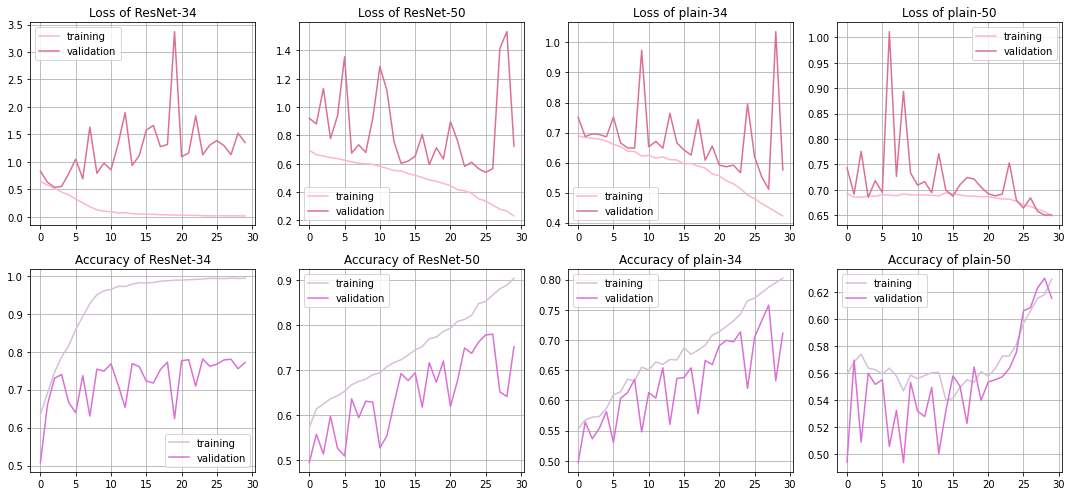

In [29]:
evaluate_4_models(experiments_dict)

**2-2. Compare loss & accuracy of between different models**

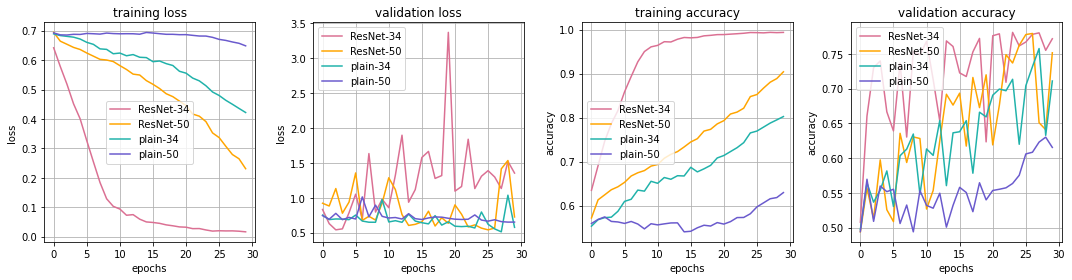

In [30]:
compare_4_models(experiments_dict)

**2-3. Evaluation**

- training loss는 ResNet-34의 경우 가장 수치가 낮고 하락폭도 크므로 좋아보이지만, validation loss는 불규칙하게 변화하는 양상을 보인다. Plain 모델은 ResNet에 비해 loss 성능은 낮지만 그 변화가 안정적이므로, 오히려 plain 모델이 ResNet보다 더 효과적인 학습을 진행하고 있다고 분석할 수도 있을 것이다.
- accuracy 차원의 성능은 ResNet-34의 경우 training/validation 상관없이 가장 높은 수치를 보였다.
- 이론상으로는 ResNet-50이 ResNet-34 보다 더욱 좋은 성능을 보여야 하고, ResNet 형태의 모델이 plain 형태의 모델보다 더욱 좋은 성능을 보여야겠지만, 실제 실험에서는 정반대의 양상을 보였다. 실전에서 딥러닝 기술을 활용하는 상황과 비교했을 때, EPOCHS=30은 충분히 작은 숫자이므로 이론 또는 실전과는 상반되는 실험 결과를 보일 수도 있다고 생각한다.

---
## <span style = "background-color: #FFFFDD"> 🍒 Conclusion</span>

**📝 회고록**  
- 아이펠을 시작한지 어언 두 달이 지났는데 직접 모델 코드 하나 짜지 못하는 게 부끄러워서💦 이번 프로젝트는 최소한의 참고자료만으로 직접 이틀동안 한땀한땀 손으로 짜봤다 😥 막상 완성하고 보니 인터넷에 돌아다니는 코드와 크게 다르지 않은 것 같지만... 그래도 스스로 너무 뿌듯하다 🥹💕 퀘스트 시간에 맞추지 못한 건 유감이지만... 한 점 부끄럼없이 열심히 했다 😭

---